In [2]:
import numpy as np
import scanpy as sc
import os
import anndata
#from methods import *
import matplotlib.pyplot as plt
import scipy
from matplotlib.pyplot import figure
import copy
import json
import gseapy
from gseapy import enrichr
from mpmath import *
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA


In [3]:
import umap

In [4]:

pids=[]
f = open('pids.txt','r')
lines=f.readlines()
for l in lines:
    pids.append(l.strip())
print(len(pids))

25


In [5]:
### load init repres and cluster labesl


reprefile = 'training_rec/init_representatives_2.txt'    #'uncertainty2_representatives.txt'
clusterfile = 'training_rec/init_cluster_labels_2.txt'      #'uncertainty2_cluster_labels.txt'

f= open(reprefile,'r')
lines=f.readlines()
init_representatives=[]
for l in lines:
    init_representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
init_cluster_labels=[]
lines=f.readlines()
for l in lines:
    init_cluster_labels.append(int(l.strip().split()[0]))
f.close()

In [6]:
hvmask = np.load('hvmask.npy')
hvset = np.load('hvset.npy')

In [7]:
bdata = anndata.read_h5ad('logbulk.h5ad')
bdata = bdata[:,hvmask]

In [7]:
sc.tl.pca(bdata)

In [10]:
import matplotlib.cm as cm
X = np.array(bdata.obsm['X_pca'])
silhouette_scores = []

for n_clusters in range(2,25,2):
    # Create a subplot with 1 row and 2 columns
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])'''

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    sc.pp.pca(bdata)
    clusterer = KMeans(n_clusters=n_clusters, random_state=10).fit(bdata.obsm['X_pca'])
    cluster_labels = clusterer.labels_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    silhouette_scores.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    

For n_clusters = 2 The average silhouette_score is : 0.5787756
For n_clusters = 4 The average silhouette_score is : 0.6300327
For n_clusters = 6 The average silhouette_score is : 0.53777236
For n_clusters = 8 The average silhouette_score is : 0.53533804
For n_clusters = 10 The average silhouette_score is : 0.39867744
For n_clusters = 12 The average silhouette_score is : 0.39001098
For n_clusters = 14 The average silhouette_score is : 0.31316078
For n_clusters = 16 The average silhouette_score is : 0.16665426
For n_clusters = 18 The average silhouette_score is : 0.12244643
For n_clusters = 20 The average silhouette_score is : 0.06758409
For n_clusters = 22 The average silhouette_score is : 0.030118527
For n_clusters = 24 The average silhouette_score is : 0.0017524621


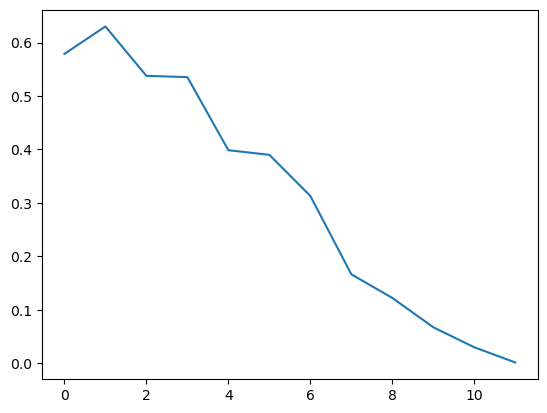

In [11]:
plt.plot(silhouette_scores)

In [8]:
pnum = 8
rnd = int(pnum/2)
reprefile = 'active_training_rec/eer_representatives_'+str(rnd)+'.txt'    #6000genebackup/
#'eer_representatives_'+str(rnd)+'.txt' #'init_representatives_4.txt'    #'uncertainty2_representatives.txt'
clusterfile = 'active_training_rec/eer_cluster_labels_'+str(rnd)+'.txt'
#'eer_cluster_labels_'+str(rnd)+'.txt' #'init_cluster_labels_4.txt'      #'uncertainty2_cluster_labels.txt'

f= open(reprefile,'r')
lines=f.readlines()
representatives=[]
for l in lines:
    representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
cluster_labels=[]
lines=f.readlines()
for l in lines:
    cluster_labels.append(int(l.strip().split()[0]))
f.close()

In [9]:
representatives

[8, 21, 1, 15, 10, 19, 13, 23]

In [100]:
pids

['iMGL_D0_rep1_TPM',
 'iMGL_D0_rep2_TPM',
 'iMGL_D0_rep3_TPM',
 'iMGL_D1_rep1_TPM',
 'iMGL_D1_rep2_TPM',
 'iMGL_D1_rep3_TPM',
 'iMGL_D2_rep1_TPM',
 'iMGL_D2_rep2_TPM',
 'iMGL_D2_rep3_TPM',
 'iMGL_D3_rep1_TPM',
 'iMGL_D3_rep2_TPM',
 'iMGL_D3_rep3_TPM',
 'iMGL_D4_rep1_TPM',
 'iMGL_D4_rep2_TPM',
 'iMGL_D4_rep3_TPM',
 'iMGL_DMSO_rep1_TPM',
 'iMGL_DMSO_rep2_TPM',
 'iMGL_GW3965_30nM_rep1_TPM',
 'iMGL_GW3965_30nM_rep2_TPM',
 'iMGL_GW3965_300nM_rep1_TPM',
 'iMGL_GW3965_300nM_rep2_TPM',
 'iMGL_T0901317_30nM_rep1_TPM',
 'iMGL_T0901317_30nM_rep2_TPM',
 'iMGL_T0901317_100nM_rep1_TPM',
 'iMGL_T0901317_100nM_rep2_TPM']

In [10]:
## load and pca together
import timeit 

t_start = timeit.default_timer()

#representatives = new_representatives#init_representatives  # newrepre
#cluster_labels = new_cluster_labels  #init_cluster_labels #nlabels

patient_id = []
sample_origin = []
celltypes = []
sample_ids=[]

gts=[]
semis=[]

semipids=[]
treatmentgt = []
treatmentsemi = []

c=0

semi_sample_origin=[]
for i in range(len(pids)):
    pid = pids[i]
    adata = anndata.read_h5ad('sample_sc/'+pids[i]+'.h5ad')
    celltype = np.array(adata.obs['celltype']).astype('str')
    
    treatment = pids[i].split('_')
    if treatment[1] in ['D0','D1','D2','D3','D4','DMSO']:
        treatment = treatment[1]
    else:
        treatment = treatment[1] + '_' + treatment[2]
    
    
    
    for j in range(adata.X.shape[0]):
        sample_ids.append(pid)
        treatmentgt.append(treatment)
    
    gts.append(np.log1p(np.array(adata.X.todense()[:,hvmask])))
    repre = representatives[cluster_labels[i]]
    reprepid = pids[repre]
    if reprepid==pid:
        semis.append(np.log1p(np.array(adata.X.todense()[:,hvmask])))
    else:
        xsem = np.load('semidata/fast'+ reprepid+'_to_'+pid+'.npy') # 6000genebackup/
        xsem = xsem*(xsem>10)
        semis.append(np.log1p(xsem))
        
    for j in range(semis[-1].shape[0]):
        semipids.append(pid)
        treatmentsemi.append(treatment)
        
    celltypes.append(celltype) # list addition
    print(i,end=', ')


t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'seconds')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
15.85914389201207 seconds


In [11]:
for i in range(25):
    if semis[i].max()>10:
        print(i)
    if gts[i].max()>10:
        print(i)

In [12]:
for i in range(25):
    if semis[i].max()<3:
        print(i)
    if gts[i].max()<3:
        print(i)

In [13]:
total_treatments = np.unique(treatmentgt)
total_treatments

array(['D0', 'D1', 'D2', 'D3', 'D4', 'DMSO', 'GW3965_300nM',
       'GW3965_30nM', 'T0901317_100nM', 'T0901317_30nM'], dtype='<U14')

In [14]:
gtdata = anndata.read_h5ad('gtdata_withcelltype.h5ad')

In [15]:
semisdata = anndata.read_h5ad('semisdata_withcelltype.h5ad')

In [116]:
gtdata.obs['treatment'] = treatmentgt
semisdata.obs['treatment'] = treatmentsemi

In [31]:
gtdata = anndata.AnnData(np.concatenate(gts,axis=0))
gtdata.var = adata.var[hvmask]
gtdata.obs['celltype'] = np.concatenate(celltypes,axis=0)
gtdata.obs['sample_ids'] = sample_ids
gtdata.obs['treatment'] = treatmentgt

semisdata = anndata.AnnData(np.concatenate(semis,axis=0))
semisdata.var = adata.var[hvmask]
semisdata.obs['sample_ids'] = semipids



In [193]:
semisdata.write('semisdata10.h5ad')
gtdata.write('gtdata10.h5ad')

In [30]:
semisdata = anndata.read_h5ad('semisdata10.h5ad')
gtdata=anndata.read_h5ad('gtdata10.h5ad')

In [17]:
combdata = anndata.read_h5ad('combdata923.h5ad')

In [81]:
gtdata.obsm['X_umap'] = combdata.obsm['X_umap'][:gtdata.X.shape[0]]

In [82]:
semisdata.obsm['X_umap'] = combdata.obsm['X_umap'][-semisdata.X.shape[0]:]

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


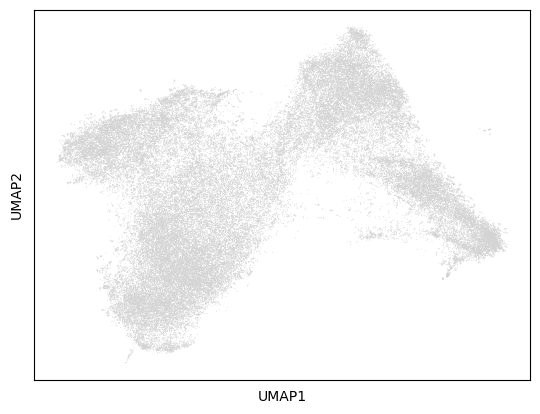

In [16]:
sc.pl.umap(semisdata)

In [83]:
## PCA  # no need if with dim alldata is loaded
t_start = timeit.default_timer()

xsemis = np.concatenate(semis,axis=0)
xgts = np.concatenate(gts,axis=0)
X = np.concatenate([xgts,xsemis],axis=0) #semidata.X],axis=0)
reducer =  PCA(n_components=100)#TruncatedSVD(n_components=100) 
X_reduced = reducer.fit_transform(X)

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'seconds')


238.94240009895293 seconds


In [84]:
# get length of gt and semi
offset=0
lengt = 0
gtpids = []
for i in range(len(pids)):
    offset = offset+gts[i].shape[0]
    for j in range(gts[i].shape[0]):
        gtpids.append(pids[i])
lengt = offset
semipids = []
for i in range(len(pids)):
    offset = offset+semis[i].shape[0]
    for j in range(semis[i].shape[0]):
        semipids.append(pids[i])
totallen = offset
lensemi = totallen-lengt

In [63]:
### umap  # no need if with dim alldata is loaded
t_start = timeit.default_timer()
import umap
umap_reduc=umap.UMAP()#min_dist = 0.5, n_neighbors = 50)
X_UMAP = umap_reduc.fit_transform(X_reduced)
t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'seconds')


78.88121408596635 seconds


In [106]:
gtdata.obsm['X_pca'] = X_reduced[:lengt]
semisdata.obsm['X_pca'] = X_reduced[lengt:]
#gtdata.obsm['X_umap'] = X_UMAP[:lengt]
#semisdata.obsm['X_umap'] = X_UMAP[lengt:]

In [30]:
lengt

74372

In [85]:
batch = []
xdimgts=[]
xdimsemis=[]
repmask = []
offset=0
xused = X_reduced#X_UMAP#X_reduced#X_UMAP # X_PCA
lengt = 0
c = 0
for i in range(len(pids)):
    xdimgts.append(xused[offset:(offset+gts[i].shape[0]),:])
    offset = offset+gts[i].shape[0]
    for j in range(len(gts[i])):
        batch.append(c)
    if i in representatives:
        for j in range(len(gts[i])):
            repmask.append(1)
    else:
        for j in range(len(gts[i])):
            repmask.append(0)
    c+=1
lengt = offset
semirepmask = []
for i in range(len(pids)):
    xdimsemis.append(xused[offset:(offset+semis[i].shape[0]),:])
    offset = offset+semis[i].shape[0]
    for j in range(len(semis[i])):
        batch.append(c)
    if i in representatives:
        for j in range(len(semis[i])):
            semirepmask.append(1)
    else:
        for j in range(len(semis[i])):
            semirepmask.append(0)
    c+=1
totallen = offset
lensemi = totallen-lengt

sklearn.svm._classes.LinearSVC

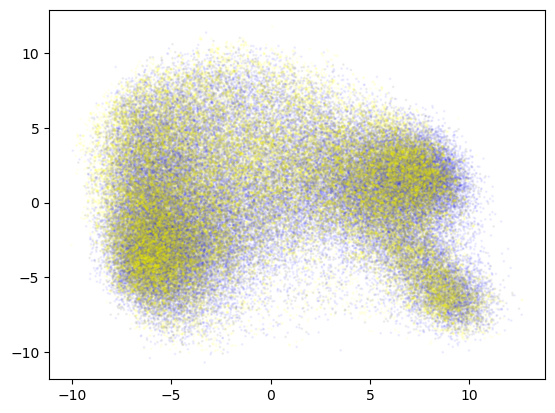

In [66]:
## not activated
color=[]
for j in range(25):
    for i in range(len(xdimgts[j])):  
        color.append('blue')
        
for j in range(25):
    for i in range(len(xdimsemis[j])):        
        color.append('yellow')

plt.scatter(xused[:,0],xused[:,1],c=color,alpha=0.05,s=1)

In [46]:
gtdata.obsm['X_umap_sc'] = gtdata.obsm['X_umap']
gtdata.obsm['X_umap'] = xused[:lengt]
gtdata.obs['celltype'] = np.array(gtdata.obs['celltype']).astype('str')
sc.pl.umap(gtdata,color = 'celltype')

KeyError: 'X_umap'

In [67]:
datalb = []
for i in range(gtdata.X.shape[0]):
    datalb.append('Original')
for i in range(semisdata.X.shape[0]):
    datalb.append('Semi-profiled')

In [68]:
combdata = anndata.AnnData(np.concatenate([gtdata.X,semisdata.X],axis=0))
combdata.obsm['X_pca'] = np.concatenate([gtdata.obsm['X_pca'],semisdata.obsm['X_pca']],axis=0)
combdata.obs['label'] = datalb

In [203]:
combdata.write('combdata10.h5ad')

In [399]:
combdata.X.shape[0]//2500

58

In [69]:
sc.pp.neighbors(combdata,n_neighbors = 50)

In [ ]:
#combdata.write('combdata10_neighbors 29.h5ad')

In [ ]:
#combdata = anndata.read('combdata_neighbors 50.h5ad')

In [70]:
sc.tl.umap(combdata, min_dist = 0.1)

In [26]:
combdata.write('combdata923.h5ad')

In [57]:
#combdata2  =anndata.read_h5ad('combdata10.h5ad')

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


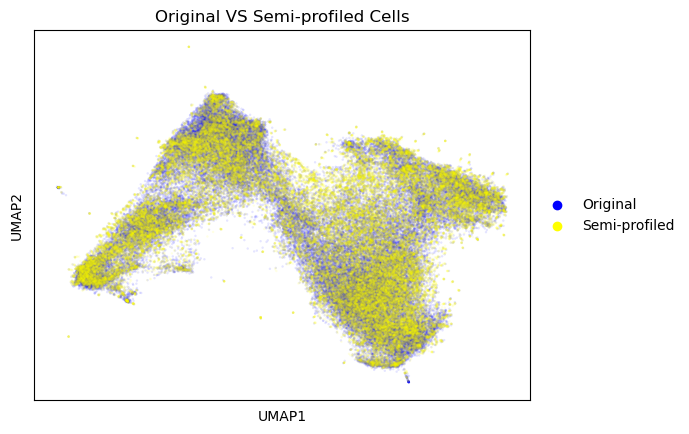

In [71]:
pointsize = 120000 / combdata.X.shape[0] * 15
#color_map = 'magma'

palette = {'Original':'blue','Semi-profiled':'yellow'}
sc.pl.umap(combdata,color = 'label',
           title = 'Original VS Semi-profiled Cells',
           size = pointsize,
           palette = palette,
           #save='ori vs semi 923.pdf',
           alpha=0.1)
#sc.pl.umap(combdata,color = 'label',title = 'Original VS Semi-profiled Cells (activation)')  #,save='ori vs semi (activation).pdf')

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


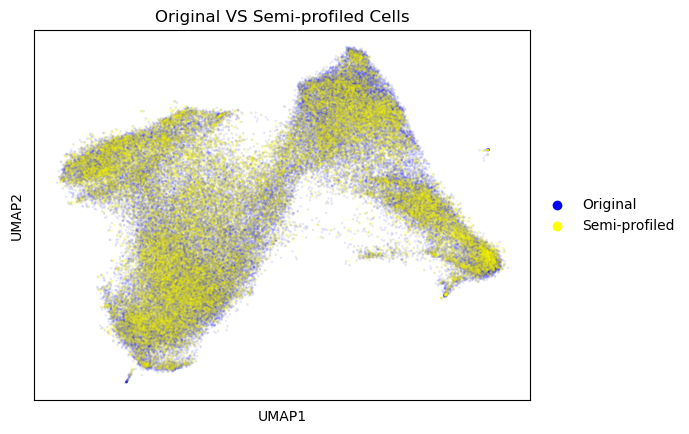

In [18]:
pointsize = 120000 / combdata.X.shape[0] * 15
#color_map = 'magma'

palette = {'Original':'blue','Semi-profiled':'yellow'}
sc.pl.umap(combdata,color = 'label',
           title = 'Original VS Semi-profiled Cells',
           size = pointsize,
           palette = palette,
           show=False,
           alpha=0.1)

fname = 'ipsc ori vs semi umap dpi600'
plt.savefig(fname+'.jpg', dpi=600, bbox_inches='tight')



/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


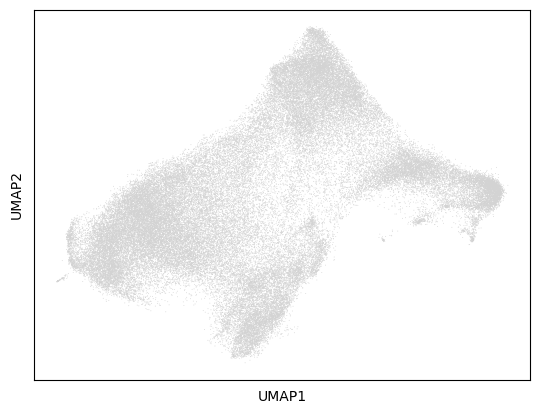

In [72]:
lengt = gtdata.X.shape[0]

In [73]:
gtdata.obsm['X_umap'] = combdata.obsm['X_umap'][:lengt]
semisdata.obsm['X_umap'] = combdata.obsm['X_umap'][lengt:]

In [74]:
gtdata.obs['ft'] = np.concatenate(celltypes,axis=0)
#gtdata.obsm['X_umap_pkg'] = gtdata.obsm['X_umap']
#gtdata.obsm['X_umap'] = combdata.obsm['X_umap'][:lengt]
#gtdata.write('gtdata.h5ad')

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


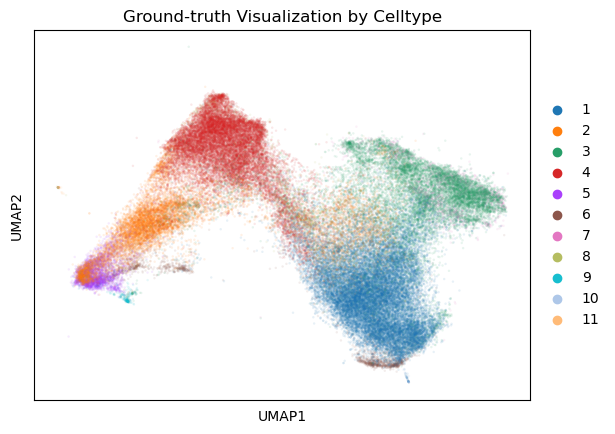

In [75]:

sc.pl.umap(gtdata,color = 'ft',
           title = 'Ground-truth Visualization by Celltype',
           size = pointsize,
           #save='gtcelltype 923.pdf',
           alpha=0.1)

In [21]:
gtdata

AnnData object with n_obs × n_vars = 74372 × 6013
    obs: 'celltype', 'sample_ids'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'celltype_colors', 'celltype_sizes', 'neighbors', 'paga'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


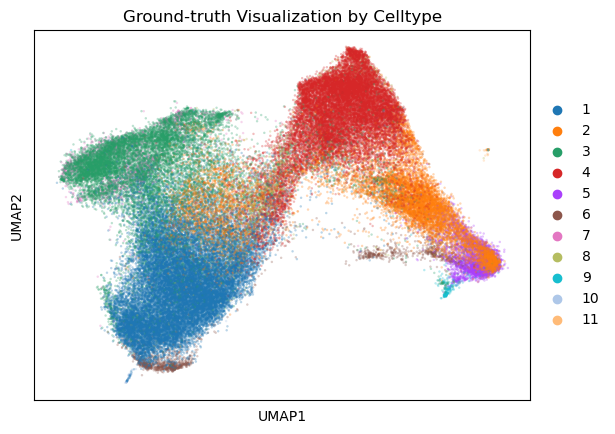

In [31]:
sc.pl.umap(gtdata,color = 'celltype',
           title = 'Ground-truth Visualization by Celltype',
           size = pointsize,
           show=False,
           alpha=0.3)

fname = 'ipsc gt a03 celltype umap dpi600'
plt.savefig(fname+'.jpg', dpi=600, bbox_inches='tight')


In [ ]:
sc.pl.umap(semisdata,color = 'celltypes',
           title = 'Semi-profiled Visualization by Celltype',
           size = pointsize,
           save='semisdatat10 923.pdf',
           alpha=0.1)

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


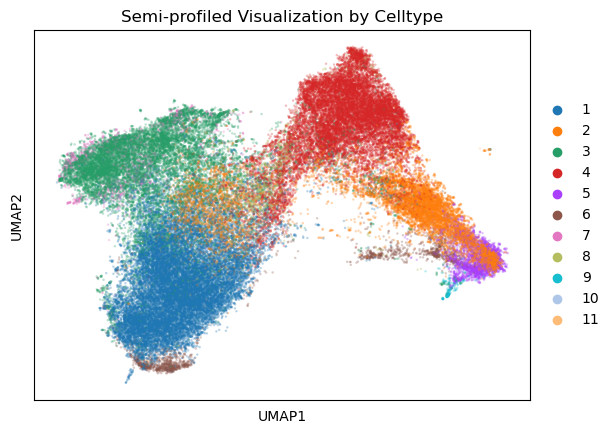

In [30]:
sc.pl.umap(semisdata,color = 'celltypes',
           title = 'Semi-profiled Visualization by Celltype',
           size = pointsize,
           show=False,
           alpha=0.3)
fname = 'ipsc semi a03 celltype umap dpi600'
plt.savefig(fname+'.jpg', dpi=600, bbox_inches='tight')

In [32]:
semisdata

AnnData object with n_obs × n_vars = 72133 × 6013
    obs: 'sample_ids', 'celltypes', 'repmask'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'celltypes_colors', 'celltypes_sizes', 'neighbors', 'paga', 'repmask_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


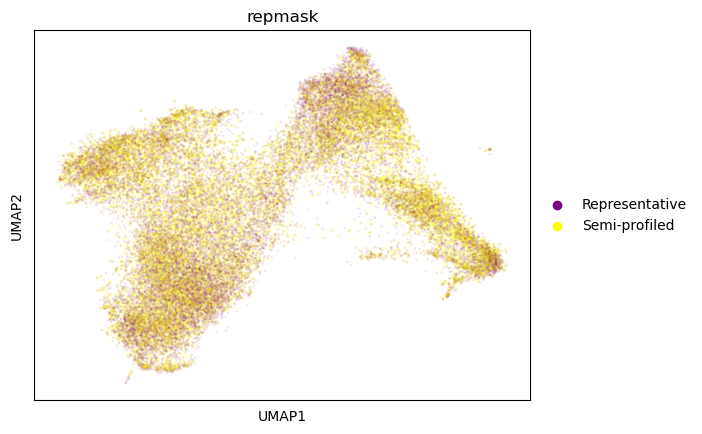

In [37]:

#pointsize = 120000 / semisdata.X.shape[0] * 30
#color_map = 'magma'
pointsize = 120000 / combdata.X.shape[0] * 15
palette = {'Representative':'purple','Semi-profiled':'yellow'}
sc.pl.umap(semisdata,color = 'repmask',
           title = 'repmask',
           size = pointsize,
           palette = palette,
           show=False,
           alpha=0.1)
fname = 'ipsc repmask umap dpi600'
plt.savefig(fname+'.jpg', dpi=600, bbox_inches='tight')


In [121]:
semisdata

AnnData object with n_obs × n_vars = 72133 × 6013
    obs: 'sample_ids', 'celltypes', 'repmask'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'repmask_colors', 'neighbors', 'paga', 'celltypes_sizes', 'celltypes_colors'
    obsm: 'X_umap', 'X_pca'
    obsp: 'distances', 'connectivities'

In [122]:
combdata

AnnData object with n_obs × n_vars = 147473 × 6013
    obs: 'label'
    uns: 'neighbors', 'umap', 'label_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [121]:
semisdata

AnnData object with n_obs × n_vars = 69080 × 6013
    obs: 'sample_ids'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [123]:
semisdata.obsm['X_umap'] = combdata.obsm['X_umap'][-semisdata.X.shape[0]:,:]

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


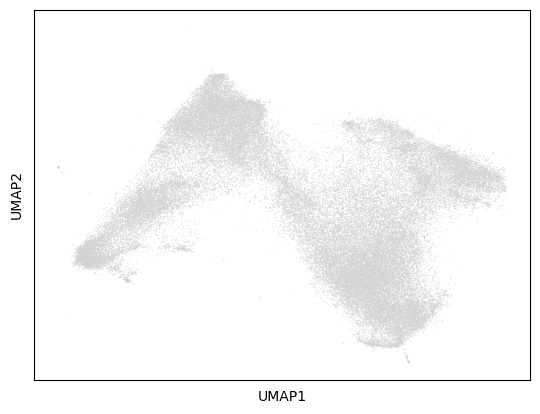

In [126]:
sc.pl.umap(gtdata)

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


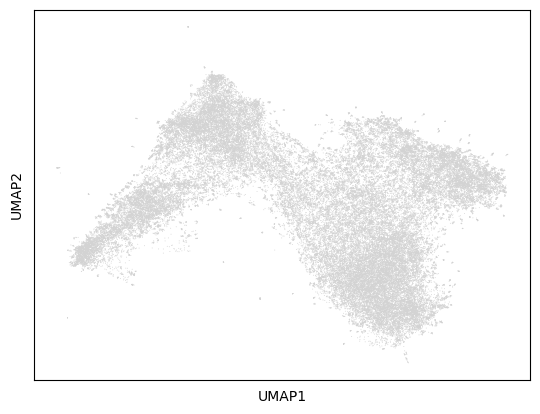

In [125]:
sc.pl.umap(semisdata)

In [128]:
from scipy import sparse

sps = sparse.csr_matrix(semisdata.X)
semisdatasps = anndata.AnnData(sps)
semisdatasps.obs = semisdata.obs
semisdatasps.var = semisdata.var
semisdatasps.obsm = semisdata.obsm
semisdatasps.write('semisdatasps.h5ad')


In [129]:
sps = sparse.csr_matrix(gtdata.X)
gtdatasps = anndata.AnnData(sps)
gtdatasps.obs = gtdata.obs
gtdatasps.var = gtdata.var
gtdatasps.obsm = gtdata.obsm
gtdatasps.write('gtdatasps.h5ad')


In [76]:
totaltypes = np.unique(gtdata.obs['celltype'])

In [77]:
gtdata.obs['celltypes'] = gtdata.obs['celltype']

In [78]:
celltypecolor =[ ]
for i in gtdata.obs['celltypes']:
    celltypecolor.append(str(list(totaltypes).index(i)))
gtdata.obs['celltypecolor'] = celltypecolor

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


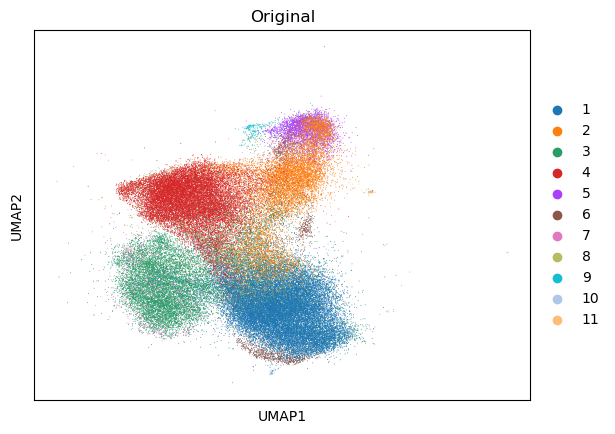

In [214]:
## only gt
sc.pl.umap(gtdata,color = 'ft',title='Original',save='originalumap 15 100.pdf')

In [215]:
semisdata.obsm['X_umap_pkg'] = semisdata.obsm['X_umap']
semisdata.obsm['X_umap'] = combdata.obsm['X_umap'][lengt:]
semisdata.write('semisdatat10.h5ad')

In [51]:
semisdata

AnnData object with n_obs × n_vars = 72133 × 6013
    obs: 'sample_ids', 'celltypes', 'repmask'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'celltypes_colors', 'celltypes_sizes', 'neighbors', 'paga', 'repmask_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [52]:
gtdata

AnnData object with n_obs × n_vars = 74372 × 6013
    obs: 'celltype', 'sample_ids'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'celltype_colors', 'celltype_sizes', 'neighbors', 'paga'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [61]:
gene_list.results

Empty DataFrame
Columns: [Gene_set, Term, Overlap, P-value, Adjusted P-value, Old P-value, Old Adjusted P-value, Odds Ratio, Combined Score, Genes]
Index: []

### Deconv

In [32]:
import sklearn
from sklearn.svm import LinearSVC

In [33]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

linearSVM = MLPClassifier()#MLPClassifier()#LinearSVC()
#linearSVM.fit(((x_train-20)*(x_train>20)), y_train)
xtrain=[]
ytrain=[]
for i in (representatives):
    xtrain.append(gts[i])
    ytrain.append(celltypes[i])
xtrain = np.concatenate(xtrain,axis=0)
ytrain = np.concatenate(ytrain,axis=0)
linearSVM.fit((xtrain),ytrain)

MLPClassifier()

In [34]:
xtrain[4].max()

6.055557

In [35]:
semis[4].max()

7.6632943

In [36]:
def deconv(svc,xtest):
    ytest = svc.predict((xtest))
    return list(ytest)

In [37]:
# get predicted label 

pcelltypes = []
for i in range(len(pids)):
    if i in representatives:
        pcelltypes.append(celltypes[i])

        continue
    pcelltypes.append(list(deconv(linearSVM,semis[i])))
    

In [38]:
len(pcelltypes)

25

In [39]:
semisdata.obs['celltypes'] = np.concatenate(pcelltypes,axis=0)

In [40]:
totaltypes = np.unique(np.concatenate(celltypes,axis=0))
#totalsubtypes =  np.unique(np.concatenate(subtypes,axis=0))
totaltypes

array(['1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype='<U21')

In [41]:
def prop(gttypes ,semitypes, totaltypes):
    pgt = np.zeros(totaltypes.shape)
    psemi = np.zeros(totaltypes.shape)
    for i in range(len(totaltypes)):
        pgt[i] += (np.array(gttypes) == totaltypes[i]).sum()
        psemi[i] += (np.array(semitypes) == totaltypes[i]).sum()  ## celltypes2
    numgt=pgt
    numsemi=psemi
    pgt = pgt/pgt.sum()
    psemi = psemi/psemi.sum()
    pcor,pval = scipy.stats.pearsonr(pgt,psemi)
    return pcor,pval,pgt,psemi,numgt,numsemi

def RMSE(p1,p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    mse = ((p1-p2)**2).sum()
    rmse = mse**0.5
    return rmse

In [42]:
# get pcors
pcors = []
pgts=[]
psemis=[]
numgts = []
numsemis = []
prmses = []
for i in range(len(pids)):
    if i in representatives:
        pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes[i],celltypes[i],totaltypes)
    pcor, pval, pgt, psemi, numgt, numsemi = prop(celltypes[i],pcelltypes[i],totaltypes)
    pcors.append(pcor)
    pgts.append(pgt)
    psemis.append(psemi)
    numgts.append(numgt.astype('float'))
    numsemis.append(numsemi.astype('float'))
    prmses.append(RMSE(pgt,psemi))


In [43]:
print(np.mean(pcors))

0.9725246374684429


In [44]:
print(np.mean(prmses))

0.06893934825780212


In [421]:
'''
SAVE DECONV RESULTS
'''

f = open('deconv/semipcor.txt','w')
for i in range(len(pcors)):
    f.write(str(pcors[i]) + '\n')
f.close()

f = open('deconv/prmses.txt','w')
for i in range(len(prmses)):
    f.write(str(prmses[i]) + '\n')
f.close()


In [45]:
iMGL_D0 = np.zeros(totaltypes.shape)
iMGL_D1 = np.zeros(totaltypes.shape)
iMGL_D2 = np.zeros(totaltypes.shape)
iMGL_D3 = np.zeros(totaltypes.shape)
iMGL_D4 = np.zeros(totaltypes.shape)
iMGL_DMSO = np.zeros(totaltypes.shape)
iMGL_GW3965_30nM = np.zeros(totaltypes.shape)
iMGL_GW3965_300nM = np.zeros(totaltypes.shape)
iMGL_T0901317_30nM = np.zeros(totaltypes.shape)
iMGL_T0901317_100nM = np.zeros(totaltypes.shape)

iMGL_D0_semi = np.zeros(totaltypes.shape)
iMGL_D1_semi = np.zeros(totaltypes.shape)
iMGL_D2_semi = np.zeros(totaltypes.shape)
iMGL_D3_semi = np.zeros(totaltypes.shape)
iMGL_D4_semi = np.zeros(totaltypes.shape)
iMGL_DMSO_semi = np.zeros(totaltypes.shape)
iMGL_GW3965_30nM_semi = np.zeros(totaltypes.shape)
iMGL_GW3965_300nM_semi = np.zeros(totaltypes.shape)
iMGL_T0901317_30nM_semi = np.zeros(totaltypes.shape)
iMGL_T0901317_100nM_semi = np.zeros(totaltypes.shape)

for i in range(len(pids)):
    if 'iMGL_D0' in pids[i]:
        iMGL_D0 += numgts[i]
        iMGL_D0_semi += numsemis[i]
    elif 'iMGL_D1' in pids[i]:
        iMGL_D1 += numgts[i]
        iMGL_D1_semi += numsemis[i]
    elif 'iMGL_D2' in pids[i]:
        iMGL_D2 += numgts[i]
        iMGL_D2_semi += numsemis[i]
    elif 'iMGL_D3' in pids[i]:
        iMGL_D3 += numgts[i]
        iMGL_D3_semi += numsemis[i]
    elif 'iMGL_D4' in pids[i]:
        iMGL_D4 += numgts[i]
        iMGL_D4_semi += numsemis[i]
    elif 'iMGL_DMSO' in pids[i]:
        iMGL_DMSO += numgts[i]
        iMGL_DMSO_semi += numsemis[i]
    elif 'iMGL_GW3965_30nM' in pids[i]:
        iMGL_GW3965_30nM += numgts[i]
        iMGL_GW3965_30nM_semi += numsemis[i]
    elif 'iMGL_GW3965_300nM' in pids[i]:
        iMGL_GW3965_300nM += numgts[i]
        iMGL_GW3965_300nM_semi += numsemis[i]
    elif 'iMGL_T0901317_30nM' in pids[i]:
        iMGL_T0901317_30nM += numgts[i]
        iMGL_T0901317_30nM_semi += numsemis[i]
    elif 'iMGL_T0901317_100nM' in pids[i]:
        iMGL_T0901317_100nM += numgts[i]
        iMGL_T0901317_100nM_semi += numsemis[i]

In [46]:
iMGL_D0 = iMGL_D0/iMGL_D0.sum()
iMGL_D1 = iMGL_D1/iMGL_D1.sum()
iMGL_D2 = iMGL_D2/iMGL_D2.sum()
iMGL_D3 = iMGL_D3/iMGL_D3.sum()
iMGL_D4 = iMGL_D4/iMGL_D4.sum()
iMGL_DMSO = iMGL_DMSO/iMGL_DMSO.sum()
iMGL_GW3965_30nM = iMGL_GW3965_30nM/iMGL_GW3965_30nM.sum()
iMGL_GW3965_300nM = iMGL_GW3965_300nM/iMGL_GW3965_300nM.sum()
iMGL_T0901317_30nM = iMGL_T0901317_30nM/iMGL_T0901317_30nM.sum()
iMGL_T0901317_100nM = iMGL_T0901317_100nM/iMGL_T0901317_100nM.sum()


iMGL_D0_semi = iMGL_D0_semi/iMGL_D0_semi.sum()
iMGL_D1_semi = iMGL_D1_semi/iMGL_D1_semi.sum()
iMGL_D2_semi = iMGL_D2_semi/iMGL_D2_semi.sum()
iMGL_D3_semi = iMGL_D3_semi/iMGL_D3_semi.sum()
iMGL_D4_semi = iMGL_D4_semi/iMGL_D4_semi.sum()
iMGL_DMSO_semi = iMGL_DMSO_semi/iMGL_DMSO_semi.sum()
iMGL_GW3965_30nM_semi = iMGL_GW3965_30nM_semi/iMGL_GW3965_30nM_semi.sum()
iMGL_GW3965_300nM_semi = iMGL_GW3965_300nM_semi/iMGL_GW3965_300nM_semi.sum()
iMGL_T0901317_30nM_semi = iMGL_T0901317_30nM_semi/iMGL_T0901317_30nM_semi.sum()
iMGL_T0901317_100nM_semi = iMGL_T0901317_100nM_semi/iMGL_T0901317_100nM_semi.sum()


In [47]:
import scipy

print(scipy.stats.pearsonr(iMGL_D0_semi,iMGL_D0))
print(scipy.stats.pearsonr(iMGL_D1_semi,iMGL_D1))
print(scipy.stats.pearsonr(iMGL_D2_semi,iMGL_D2))
print(scipy.stats.pearsonr(iMGL_D3_semi,iMGL_D3))
print(scipy.stats.pearsonr(iMGL_D4_semi,iMGL_D4))

print(scipy.stats.pearsonr(iMGL_DMSO_semi,iMGL_DMSO))
print(scipy.stats.pearsonr(iMGL_GW3965_30nM_semi,iMGL_GW3965_30nM))
print(scipy.stats.pearsonr(iMGL_GW3965_300nM_semi,iMGL_GW3965_300nM))
print(scipy.stats.pearsonr(iMGL_T0901317_30nM_semi,iMGL_T0901317_30nM))
print(scipy.stats.pearsonr(iMGL_T0901317_100nM_semi,iMGL_T0901317_100nM))

PearsonRResult(statistic=0.99872945823127, pvalue=5.427183811343023e-13)
PearsonRResult(statistic=0.8712047662717323, pvalue=0.000478508598524389)
PearsonRResult(statistic=0.9927701133936422, pvalue=1.345873835073169e-09)
PearsonRResult(statistic=0.9886234332463093, pvalue=1.028905800383836e-08)
PearsonRResult(statistic=0.9917003347236286, pvalue=2.5004495984199844e-09)
PearsonRResult(statistic=0.9982876540329899, pvalue=2.077357332856563e-12)
PearsonRResult(statistic=0.9596314543596745, pvalue=2.9465569745303856e-06)
PearsonRResult(statistic=0.9988595264664304, pvalue=3.3387864104746514e-13)
PearsonRResult(statistic=0.9874516914760001, pvalue=1.5967119504511658e-08)
PearsonRResult(statistic=0.9985826468538613, pvalue=8.875324814410537e-13)


array(['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
       '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78'],
      dtype=object)

In [95]:
colormap = ['yellow','blue','gray','red','green','black','darkgreen','darkorange','crimson',\
            'purple','navy','aquamarine','plum','violet','olive','steelblue','brown','pink']

In [96]:
len(totaltypes)

11

In [97]:
import matplotlib.patches as mpatches
def stackedbar(percentages = [iMGL_D0_semi,iMGL_D1_semi,iMGL_D2_semi,\
                              iMGL_D3_semi,iMGL_D4_semi,iMGL_DMSO_semi,\
                              iMGL_GW3965_30nM_semi,iMGL_GW3965_300nM_semi,iMGL_T0901317_30nM_semi,iMGL_T0901317_100nM_semi],\
               totaltypes=totaltypes,\
               colormap=colormap,\
               save = True,\
               title = 'Ground Truth'\
               ):
    
    
    
    ylabels = ['iMGL_D0',
'iMGL_D1',
'iMGL_D2',
'iMGL_D3' ,
'iMGL_D4' ,
'iMGL_DMSO' ,
'iMGL_GW3965_30nM' ,
'iMGL_GW3965_300nM' ,
'iMGL_T0901317_30nM' ,
'iMGL_T0901317_100nM' ]
    
    # Create a horizontal stacked bar chart for Condition 1
    fig, [ax0, ax1, ax2, ax3,ax4,ax5,ax6,ax7,ax8,ax9] = plt.subplots(10,1,figsize = (8,2))
    ax = [ax0, ax1, ax2, ax3,ax4,ax5,ax6,ax7,ax8,ax9]
    ax0.set_title(title)
    
    
    for j in range(len(ylabels)):
        for i in range(len(totaltypes)):
            ax[j].barh(ylabels[j], percentages[j][i], left=sum(percentages[j][:i]),color=colormap[i])
            ax[j].set_ylabel(ylabels[j],rotation=0,ha='right',y=-0.05)
            ax[j].set_xlim([0, 1])
            ax[j].set_yticklabels([])
            ax[j].yaxis.set_tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
            if j != 7:
                ax[j].set_xticklabels([])
    
    
    patches = []
    for i in range(len(totaltypes)):
        patches.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches, loc='center left', bbox_to_anchor=(1.1, 5))

    '''
    patches1 = []
    for i in range(len(totaltypes)//2):
        patches1.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-2].legend(handles=patches1, loc='center left', bbox_to_anchor=(1.07, 3.8))
    
    patches2 = []
    for i in range(9,18):
        patches2.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches2, loc='center left', bbox_to_anchor=(1.3, 5))
    '''
    
    plt.xlabel('Proportion')
    
    if save != False:
        if save == True:
            path = 'stackedbar.png'
        else:
            path = save
        plt.savefig(path,dpi=600,bbox_inches='tight')
    # Create a legend for the chart
    #legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors_1]
    #plt.legend(legend_handles, categories_1, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the chart
    #plt.show()


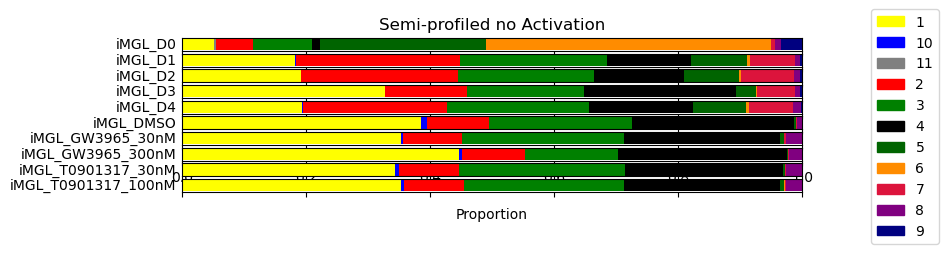

In [98]:
stackedbar(\
          save = 'stackedbar_semi 923 6.pdf',title = 'Semi-profiled no Activation')

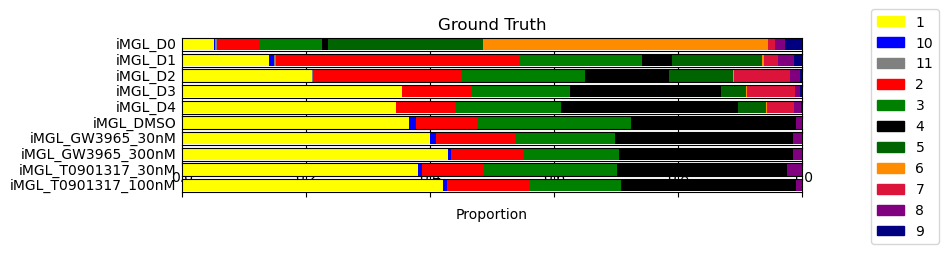

In [99]:
stackedbar(percentages = [iMGL_D0,
iMGL_D1,
iMGL_D2,
iMGL_D3 ,
iMGL_D4 ,
iMGL_DMSO ,
iMGL_GW3965_30nM ,
iMGL_GW3965_300nM ,
iMGL_T0901317_30nM ,
iMGL_T0901317_100nM ] ,save = 'stackedbar_gt923 6.pdf')

In [100]:
cpsemi = [iMGL_D0,
iMGL_D1,
iMGL_D2,
iMGL_D3 ,
iMGL_D4 ,
iMGL_DMSO ,
iMGL_GW3965_30nM ,
iMGL_GW3965_300nM ,
iMGL_T0901317_30nM ,
iMGL_T0901317_100nM ]
cpgt = [iMGL_D0_semi,
iMGL_D1_semi,
iMGL_D2_semi,
iMGL_D3_semi ,
iMGL_D4_semi ,
iMGL_DMSO_semi ,
iMGL_GW3965_30nM_semi ,
iMGL_GW3965_300nM_semi ,
iMGL_T0901317_30nM_semi ,
iMGL_T0901317_100nM_semi ]
severity=  ['iMGL_D0',
'iMGL_D1',
'iMGL_D2',
'iMGL_D3' ,
'iMGL_D4' ,
'iMGL_DMSO' ,
'iMGL_GW3965_30nM' ,
'iMGL_GW3965_300nM' ,
'iMGL_T0901317_30nM' ,
'iMGL_T0901317_100nM' ]
for i in range(8):
    print(severity[i],scipy.stats.pearsonr(cpgt[i],cpsemi[i])[0])

iMGL_D0 0.9986796316503042
iMGL_D1 0.8815313258735964
iMGL_D2 0.9939244637117737
iMGL_D3 0.9917039794570566
iMGL_D4 0.773930279498667
iMGL_DMSO 0.9980008981920971
iMGL_GW3965_30nM 0.9615361494741981
iMGL_GW3965_300nM 0.9985612888055753


In [466]:
# seg data for psuedo time analysis
d0mask = []
d1mask=[]
d2mask=[]
d3mask=[]
d4mask=[]
dmsomask=[]
gw30mask = []
gw300mask = []
t30mask=[]
t100mask=[]
for i in range(gtdata.X.shape[0]):
    if 'D0' in gtdata.obs['sample_ids'][i]:
        d0mask.append(True)
    else:
        d0mask.append(False)
        
    if 'D1' in gtdata.obs['sample_ids'][i]:
        d1mask.append(True)
    else:
        d1mask.append(False)
        
    if 'D2' in gtdata.obs['sample_ids'][i]:
        d2mask.append(True)
    else:
        d2mask.append(False)
        
    if 'D3' in gtdata.obs['sample_ids'][i]:
        d3mask.append(True)
    else:
        d3mask.append(False)
    
    if 'D4' in gtdata.obs['sample_ids'][i]:
        d4mask.append(True)
    else:
        d4mask.append(False)

    if 'DMSO' in gtdata.obs['sample_ids'][i]:
        dmsomask.append(True)
    else:
        dmsomask.append(False)
    
    
    
    if 'GW3965_30nM' in gtdata.obs['sample_ids'][i]:
        gw30mask.append(True)
    else:
        gw30mask.append(False)
        
        
        
    if 'GW3965_300nM' in gtdata.obs['sample_ids'][i]:
        gw300mask.append(True)
    else:
        gw300mask.append(False)
        
    if 'T0901317_30nM' in gtdata.obs['sample_ids'][i]:
        t30mask.append(True)
    else:
        t30mask.append(False)
        
        
    if 'T0901317_100nM' in gtdata.obs['sample_ids'][i]:
        t100mask.append(True)
    else:
        t100mask.append(False)
        
gtd0 = gtdata[d0mask]
gtd1 = gtdata[d1mask]
gtd2 = gtdata[d2mask]
gtd3 = gtdata[d3mask]
gtd4 = gtdata[d4mask]

gtdmso = gtdata[dmsomask]

gtgw30 = gtdata[gw30mask]
gtgw300 = gtdata[gw300mask]
gtt30 = gtdata[t30mask]
gtt100 = gtdata[t100mask]



gtd0.write('typedata/gtd0.h5ad')
gtd1.write('typedata/gtd1.h5ad')
gtd2.write('typedata/gtd2.h5ad')
gtd3.write('typedata/gtd3.h5ad')
gtd4.write('typedata/gtd4.h5ad')
gtdmso.write('typedata/gtdmso.h5ad')
gtgw30.write('typedata/gtgw30.h5ad')
gtgw300.write('typedata/gtgw300.h5ad')
gtt30.write('typedata/gtt30.h5ad')
gtt100.write('typedata/gtt100.h5ad')



In [467]:
del gtd0
del gtd1
del gtd2
del gtd3
del gtd4
del gtdmso
del gtgw30
del gtgw300
del gtt30
del gtt100


In [470]:
semid0mask = []
semid1mask=[]
semid2mask=[]
semid3mask=[]
semid4mask=[]
semidmsomask=[]
semigw30mask = []
semigw300mask = []
semit30mask=[]
semit100mask=[]
for i in range(semisdata.X.shape[0]):
    if 'D0' in semisdata.obs['sample_ids'][i]:
        semid0mask.append(True)
    else:
        semid0mask.append(False)
        
    if 'D1' in semisdata.obs['sample_ids'][i]:
        semid1mask.append(True)
    else:
        semid1mask.append(False)
        
    if 'D2' in semisdata.obs['sample_ids'][i]:
        semid2mask.append(True)
    else:
        semid2mask.append(False)
        
    if 'D3' in semisdata.obs['sample_ids'][i]:
        semid3mask.append(True)
    else:
        semid3mask.append(False)
    
    if 'D4' in semisdata.obs['sample_ids'][i]:
        semid4mask.append(True)
    else:
        semid4mask.append(False)

    if 'DMSO' in semisdata.obs['sample_ids'][i]:
        semidmsomask.append(True)
    else:
        semidmsomask.append(False)
    
    
    
    if 'GW3965_30nM' in semisdata.obs['sample_ids'][i]:
        semigw30mask.append(True)
    else:
        semigw30mask.append(False)
        
        
        
    if 'GW3965_300nM' in semisdata.obs['sample_ids'][i]:
        semigw300mask.append(True)
    else:
        semigw300mask.append(False)
        
    if 'T0901317_30nM' in semisdata.obs['sample_ids'][i]:
        semit30mask.append(True)
    else:
        semit30mask.append(False)
        
        
    if 'T0901317_100nM' in semisdata.obs['sample_ids'][i]:
        semit100mask.append(True)
    else:
        semit100mask.append(False)
        
semid0 = semisdata[semid0mask]
semid1 = semisdata[semid1mask]
semid2 = semisdata[semid2mask]
semid3 = semisdata[semid3mask]
semid4 = semisdata[semid4mask]

semidmso = semisdata[semidmsomask]

semigw30 = semisdata[semigw30mask]
semigw300 = semisdata[semigw300mask]
semit30 = semisdata[semit30mask]
semit100 = semisdata[semit100mask]



semid0.write('typedata/semid0.h5ad')
semid1.write('typedata/semid1.h5ad')
semid2.write('typedata/semid2.h5ad')
semid3.write('typedata/semid3.h5ad')
semid4.write('typedata/semid4.h5ad')
semidmso.write('typedata/semidmso.h5ad')
semigw30.write('typedata/semigw30.h5ad')
semigw300.write('typedata/semigw300.h5ad')
semit30.write('typedata/semit30.h5ad')
semit100.write('typedata/semit100.h5ad')



In [471]:
del semid0
del semid1
del semid2
del semid3
del semid4
del semidmso
del semigw30
del semigw300
del semit30
del semit100


### deconv benchmarking

In [61]:
# for bisque
# pid of each cell
pidlist = []
alldata=anndata.read_h5ad('gtdata.h5ad')
for i in representatives:
    repdata = alldata[alldata.obs['sample_ids'] == pids[i]]
    pidlist = pidlist + list(repdata.obs['sample_ids'])
    

In [62]:
f=open('ref_pids.txt','w')
for i in pidlist:
    f.write(i+'\n')
f.close()

### end of deconv benchmarking

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


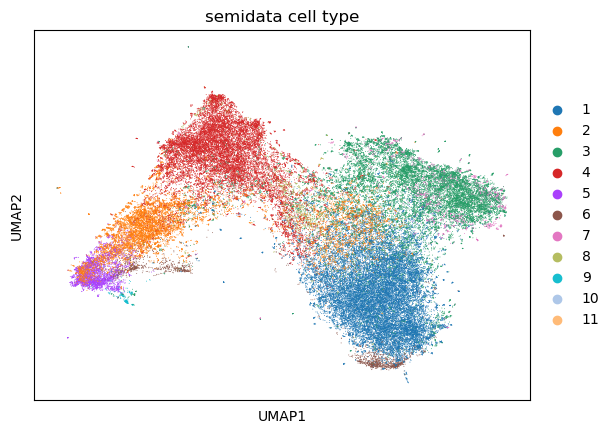

In [101]:
pointsize = 120000 / combdata.X.shape[0] * 2
#color_map = 'magma'


sc.pl.umap(semisdata,size=pointsize,title='semidata cell type',color='celltypes',save = 'semi celltype 6.pdf')


In [102]:
semisdata = anndata.read_h5ad('semisdatat10.h5ad')
semisdata

AnnData object with n_obs × n_vars = 69080 × 6013
    obs: 'sample_ids'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'X_pca', 'X_umap', 'X_umap_pkg'

In [ ]:
semirepmask = []
reppids = []
for i in representatives:
    reppids.append(pids[i])
for i in range(semisdata.X.shape[0]):
    if semisdata.obs['sample_ids'][i] in reppids:
        semirepmask.append('Representative')
    else:
        semirepmask.append('Semi-profiled')

In [ ]:
semisdata

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


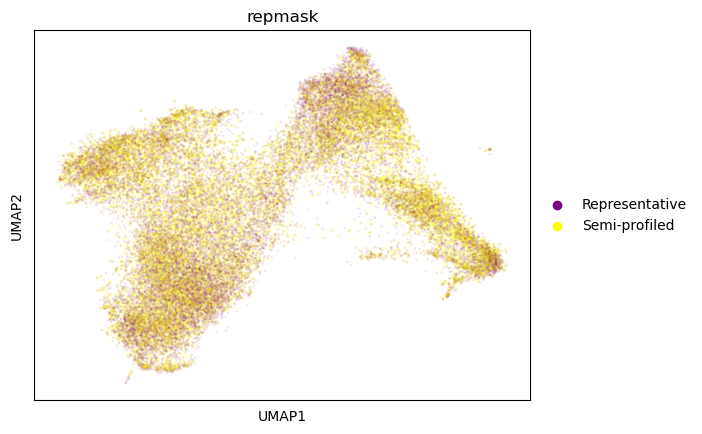

In [123]:

## only semis

#semisdata.obs['repmask'] = np.array(semirepmask).astype('str')
semisdata.obs['repmask'] = semirepmask
pointsize = 120000 / combdata.X.shape[0] * 15
#color_map = 'magma'

palette = {'Representative':'purple','Semi-profiled':'yellow'}
sc.pl.umap(semisdata,color = 'repmask',
           title = 'repmask',
           size = pointsize,
           palette = palette,
           save=' semisdatat10 8rep repmask 103 8.pdf',
           alpha=0.1)

In [51]:
semisdata.write('semisdata930withrep.h5ad')

In [432]:
gtdata

AnnData object with n_obs × n_vars = 74372 × 6013
    obs: 'celltype', 'sample_ids', 'ft'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'ft_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_pkg'

In [38]:

# pval functions
from mpmath import *
mp.dps=500
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpmath import *
def comb(a,b):
    a=mp.mpf(a)
    b=mp.mpf(b)
    cab = fac(a)/fac(a-b)/fac(b)
    return cab

def hyperp(N,n1,n2,k):
    N = mp.mpf(N)
    n1 = mp.mpf(n1)
    n2 = mp.mpf(n2)
    k = mp.mpf(k)
    p = comb(n2,k)*comb(N-n2,n1-k)/comb(N,n1)
    return p 

def hypert(N,n1,n2,k):
    cdf = mp.mpf(0)
    for i in range(0,int(k)+1):
        cdf += hyperp(N,n1,n2,i)
       # print()
    return (1-cdf)

genesum = 6000
a = 100
b = 100
overlap = 94

p_value = hypert(genesum,a,b,overlap)
print(float(p_value))

1.466403272131815e-195


### heatmap ipsc

In [130]:
f = open('../cancer/immune_response.txt','r')
lines = f.readlines()
neurondiffgenes = []
for l in lines:
    neurondiffgenes.append(l.strip())


In [131]:
len(neurondiffgenes)

349

In [132]:
sc.tl.score_genes(gtdata, neurondiffgenes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='neuron_differentiation_score', random_state=0, copy=False, use_raw=None)

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [134]:
len(['ABL1', 'ALPK1', 'AP3B1', 'BANK1', 'BAX', 'BCAR1', 'BCL10', 'BLK', 'BLNK', 'BTK', 'BTN1A1', 'BTN2A1', 'BTN3A1', 'BTN3A3', 'BTNL2', 'BTNL3', 'BTNL8', 'C1QBP', 'C1QC', 'C1R', 'C1RL', 'C1S', 'C2', 'C3', 'C3AR1', 'C4A', 'C4B', 'C4BPA', 'C4B_2', 'C5', 'C5AR1', 'C5AR2', 'C6', 'C7', 'C8A', 'C8G', 'CACNB3', 'CACNB4', 'CARD8', 'CASP6', 'CD14', 'CD276', 'CD28', 'CD300LF', 'CD38', 'CD40', 'CD46', 'CD55', 'CD79A', 'CD79B', 'CD8A', 'CD8B', 'CFB', 'CFD', 'CFHR2', 'CFHR3', 'CFHR4', 'CFHR5', 'CFI', 'CFP', 'CGAS', 'CHUK', 'CLEC4E', 'CLEC6A', 'CLEC7A', 'CLPB', 'CLU', 'CMKLR1', 'COLEC10', 'CR2', 'CTLA4', 'CTSS', 'DENND1B', 'DHX58', 'ECSIT', 'EIF2B1', 'EPG5', 'FCER1G', 'FCHO1', 'FCN2', 'FCN3', 'FFAR2', 'FOSL1', 'FPR1', 'FPR3', 'FYB1', 'FYB2', 'GATA3', 'GBP2', 'GPLD1', 'GPR32', 'GPR33', 'GRB2', 'HCK', 'HEXIM1', 'HHLA2', 'HLA-DPB1', 'HMGB1', 'HMSD', 'HSPD1', 'IFIH1', 'IKBKG', 'INAVA', 'IRAK1', 'IRAK2', 'IRAK3', 'IRF7', 'ITK', 'KCNJ8', 'KHDRBS1', 'KIR2DS2', 'KLHL6', 'KLRC1', 'KLRC2', 'KLRK1', 'KRT1', 'LACC1', 'LAT', 'LBP', 'LCP2', 'LGALS9', 'LILRA2', 'LIMK1', 'LRRC19', 'LSM14A', 'LY96', 'MALT1', 'MAP3K7', 'MAPK1', 'MAPKAPK2', 'MAPKAPK3', 'MASP1', 'MATR3', 'MAVS', 'MBL2', 'MEFV', 'MYD88', 'MYO1G', 'NCR3', 'NFAM1', 'NFATC2', 'NFKBID', 'NFKBIZ', 'NLRC4', 'NLRP10', 'NLRP3', 'NLRP6', 'NMI', 'NOD1', 'NOD2', 'NONO', 'NR1H4', 'NR4A3', 'PAK2', 'PAK3', 'PDE4B', 'PDE4D', 'PHB1', 'PIK3AP1', 'PIK3CA', 'PIK3CD', 'PLA2G6', 'PLCG1', 'PLCG2', 'PRKCB', 'PRKD2', 'PRKDC', 'PSEN1', 'PSPC1', 'PTK2', 'PTPN22', 'PTPN6', 'PTPRJ', 'PYCARD', 'RBM14', 'RBM14-RBM4', 'RC3H1', 'REG3G', 'RELA', 'RIGI', 'RNF135', 'RPS6KA3', 'S100A14', 'SCARA3', 'SERPING1', 'SHB', 'SIN3A', 'SIRT2', 'SKAP1', 'SLA2', 'SLC39A6', 'SOS1', 'SPPL3', 'STING1', 'STK11', 'SUSD4', 'SYK', 'TBK1', 'THEMIS', 'THEMIS2', 'THY1', 'TICAM1', 'TIFA', 'TIRAP', 'TLR2', 'TLR3', 'TLR5', 'TLR6', 'TLR7', 'TMEM126A', 'TMIGD2', 'TNF', 'TNIP1', 'TNIP2', 'TNIP3', 'TOMM70', 'TRAF3', 'TRAF6', 'TREX1', 'TRIL', 'TRIM25', 'TRIM5', 'TXK', 'TYROBP', 'UNC93B1', 'VAV1', 'VAV2', 'WNK1', 'XIAP', 'YES1', 'YWHAE', 'ZBP1', 'ZNFX1'])

233

In [133]:
sc.tl.score_genes(semisdata, neurondiffgenes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='neuron_differentiation_score', random_state=0, copy=False, use_raw=None)

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


In [70]:
len(['ABI1', 'ABITRAM', 'ABL1', 'ABT1', 'ACSL3', 'ACSL4', 'ACTB', 'ACTBL2', 'ACTL6B', 'ACTL9', 'ADAM17', 'ADARB1', 'ADCY10', 'ADCYAP1', 'ADGRF1', 'ADNP', 'AFG3L2', 'AGER', 'AGRN', 'ALCAM', 'ALDH1A2', 'ALK', 'ALS2', 'ANK3', 'ANKRD24', 'ANKS1A', 'APBB1', 'APBB2', 'APLP2', 'APOA4', 'APOD', 'APOE', 'APP', 'ARC', 'AREG', 'ARHGEF25', 'ARHGEF40', 'ASCL2', 'ATCAY', 'ATF4', 'ATF5', 'ATL1', 'ATOH1', 'ATOH7', 'ATP7A', 'ATP8B1', 'ATP9A', 'ATXN10', 'AURKA', 'B4GALT6', 'B4GAT1', 'BAIAP2', 'BARHL2', 'BBS1', 'BBS4', 'BCL11B', 'BCL6', 'BDNF', 'BECN1', 'BHLHA15', 'BHLHE22', 'BHLHE23', 'BICDL1', 'BLOC1S2', 'BLOC1S3', 'BLOC1S6', 'BMP2', 'BMP4', 'BMP6', 'BMP7', 'BMPR1A', 'BOC', 'BRINP1', 'BRINP2', 'BRINP3', 'BRSK1', 'BRSK2', 'BTBD3', 'BTG2', 'BTG4', 'BUB1B-PAK6', 'C12orf57', 'C1QL1', 'C21orf91', 'C3', 'CABP4', 'CAMSAP2', 'CAMSAP3', 'CASP3', 'CBLN1', 'CCK', 'CCKAR', 'CCND1', 'CDC42', 'CDH1', 'CDH11', 'CDH4', 'CDHR1', 'CDK16', 'CDK5', 'CDK5R1', 'CDK5R2', 'CDKL3', 'CDNF', 'CDON', 'CEBPB', 'CECR2', 'CEND1', 'CEP290', 'CFAP418', 'CHL1', 'CHN1', 'CHRFAM7A', 'CHRNA7', 'CHRNB2', 'CLRN1', 'CLRN2', 'CNGB1', 'CNTN1', 'CNTN2', 'CNTN5', 'CNTN6', 'CNTNAP1', 'CNTNAP2', 'CPNE1', 'CRB1', 'CRB2', 'CRK', 'CRPPA', 'CRTAC1', 'CSPG5', 'CTF1', 'CTNNA2', 'CX3CL1', 'CXCR4', 'CYB5D2', 'CYFIP1', 'CYFIP2', 'DAB1', 'DBX1', 'DCC', 'DCLK1', 'DCLK2', 'DDR1', 'DGKG', 'DIO3', 'DISC1', 'DLX2', 'DMD', 'DMRT3', 'DNM2', 'DNMT3A', 'DOCK10', 'DOK5', 'DPYSL3', 'DPYSL5', 'DRAXIN', 'DRD1', 'DRD2', 'DRGX', 'DSCAM', 'DSCAML1', 'DTNBP1', 'ECE1', 'EDN1', 'EDN2', 'EDN3', 'EDNRA', 'EFNA2', 'EFNA5', 'EFNB1', 'EFNB2', 'EGR2', 'EHD1', 'EHMT2', 'EIF4G1', 'ELAVL4', 'EMB', 'EMX1', 'EMX2', 'EN1', 'EPB41L3', 'EPHA10', 'EPHA3', 'EPHA4', 'EPHA5', 'EPHA6', 'EPHA7', 'EPHA8', 'EPHB1', 'EPHB3', 'EPHB6', 'ERBB2', 'ERBB4', 'ERCC2', 'ERCC3', 'ERCC6', 'ETV1', 'EVX1', 'EXT1', 'EYA1', 'FAIM2', 'FAM151B', 'FARP1', 'FEV', 'FEZ2', 'FEZF1', 'FEZF2', 'FGF2', 'FGF20', 'FGF8', 'FGFR2', 'FIG4', 'FLOT1', 'FLRT1', 'FLRT3', 'FOXA1', 'FOXA2', 'FOXB1', 'FOXD1', 'FOXG1', 'FOXN4', 'FRY', 'FSCN2', 'FUT9', 'FZD1', 'FZD10', 'FZD7', 'FZD8', 'GABRA5', 'GABRB2', 'GAP43', 'GATA3', 'GBA1', 'GBA2', 'GBX1', 'GBX2', 'GFAP', 'GFRA1', 'GFRA3', 'GHRL', 'GIGYF2', 'GIT1', 'GLDN', 'GLI2', 'GLI3', 'GPC2', 'GPM6B', 'GPRIN2', 'GPRIN3', 'GRID2', 'GRIN3A', 'GRM7', 'GRXCR1', 'GRXCR2', 'GSDME', 'GSX1', 'GSX2', 'HAND2', 'HCN1', 'HDAC1', 'HDAC6', 'HDGFL3', 'HELT', 'HERC1', 'HES1', 'HEXA', 'HIF1A', 'HIPK2', 'HMGB1', 'HOXC10', 'HOXC8', 'HOXD1', 'HOXD10', 'HOXD9', 'HS6ST1', 'ID2', 'ID4', 'IER2', 'IFT140', 'IFT172', 'IFT20', 'IFT27', 'IFT88', 'IGF1R', 'IGF2BP1', 'IGSF9', 'IHH', 'IL1RAPL1', 'IL6', 'IMPACT', 'INHBA', 'INSM1', 'INSM2', 'IQGAP1', 'IQSEC1', 'IRX1', 'IRX3', 'IRX4', 'IRX5', 'ISL1', 'ISL2', 'IST1', 'ITGA1', 'ITGA4', 'ITM2C', 'JAG1', 'JAG2', 'JAK2', 'KALRN', 'KCNA1', 'KCNB1', 'KCNQ1', 'KDM1A', 'KIF20B', 'KIF5A', 'KIF5C', 'KIRREL3', 'KLF7', 'KLHL1', 'KLK8', 'L1CAM', 'LAMA1', 'LAMB2', 'LBX1', 'LDB1', 'LEP', 'LGI1', 'LGI4', 'LGR6', 'LHFPL5', 'LHX1', 'LHX2', 'LHX3', 'LHX4', 'LHX8', 'LHX9', 'LIF', 'LIMK1', 'LLGL1', 'LLPH', 'LMO4', 'LMX1A', 'LNX2', 'LPAR3', 'LRP6', 'LRP8', 'LRRK2', 'LRTM1', 'LRTM2', 'LSM1', 'LYPLA2', 'MAG', 'MAP1A', 'MAP1B', 'MAP1S', 'MAP2K1', 'MAP4K4', 'MAP6', 'MAPK8IP2', 'MAPT', 'MARK2', 'MATN2', 'MBD1', 'MCF2', 'MDGA2', 'MECP2', 'MEF2A', 'MEGF8', 'MET', 'METRN', 'MFRP', 'MGARP', 'MICALL1', 'MICALL2', 'MICOS10-NBL1', 'MMP2', 'MNX1', 'MTCH1', 'MTMR2', 'MTPN', 'MTR', 'MYEF2', 'MYO7A', 'MYOC', 'MYOT', 'MYPN', 'NAP1L2', 'NAPA', 'NCAM1', 'NCDN', 'NCKAP1', 'NDEL1', 'NDNF', 'NECTIN1', 'NEFH', 'NEFL', 'NEGR1', 'NEK3', 'NELL2', 'NEO1', 'NEUROD1', 'NEUROD2', 'NEUROD4', 'NEUROD6', 'NEUROG1', 'NEUROG2', 'NEUROG3', 'NEXN', 'NFASC', 'NFATC4', 'NFIA', 'NGFR', 'NGRN', 'NHERF1', 'NIBAN2', 'NIF3L1', 'NKX2-1', 'NKX2-2', 'NKX2-8', 'NKX6-1', 'NKX6-2', 'NLGN1', 'NLGN3', 'NLGN4X', 'NMNAT2', 'NOG', 'NOTCH1', 'NOTCH2', 'NOTCH3', 'NOTO', 'NOVA2', 'NPR2', 'NPTX1', 'NPY', 'NR2E1', 'NR2E3', 'NR2F6', 'NR4A2', 'NRBP2', 'NRCAM', 'NREP', 'NRP2', 'NRTN', 'NRXN1', 'NRXN3', 'NTF3', 'NTF4', 'NTN3', 'NTN4', 'NTNG1', 'NTNG2', 'NTRK1', 'NTRK2', 'NUMBL', 'NYAP1', 'OGDH', 'OLIG1', 'OLIG2', 'OLIG3', 'OMG', 'ONECUT2', 'OPHN1', 'OR10A4', 'OTP', 'OTX2', 'PACSIN1', 'PAFAH1B1', 'PAK2', 'PAK3', 'PALS1', 'PAX2', 'PBX1', 'PBX2', 'PBX3', 'PCDH12', 'PCDHAC2', 'PCSK9', 'PEX5', 'PGRMC1', 'PHOX2A', 'PHOX2B', 'PICK1', 'PIGT', 'PIN1', 'PITPNA', 'PJVK', 'PLA2G10', 'PLEKHG4', 'PLEKHG4B', 'PLP1', 'PLPPR4', 'PLS1', 'PLXNA1', 'PLXNA3', 'PLXNB1', 'PLXNB2', 'PLXNB3', 'PLXNC1', 'PLXND1', 'POSTN', 'POTEE', 'POTEF', 'POTEI', 'POTEJ', 'POU3F2', 'POU4F2', 'PPIA', 'PPP1CC', 'PPP1R9B', 'PPP3CA', 'PPP3CB', 'PPT1', 'PRDM1', 'PRDM13', 'PREX2', 'PRICKLE1', 'PRKCI', 'PRKCQ', 'PRMT1', 'PROM1', 'PROX1', 'PRPH2', 'PRRX1', 'PSEN1', 'PTF1A', 'PTK2', 'PTK2B', 'PTK7', 'PTPRF', 'PTPRM', 'PTPRO', 'PTPRZ1', 'RAB11A', 'RAB13', 'RAB35', 'RAB3A', 'RAB6A', 'RAB6B', 'RAB8A', 'RAC1', 'RAC3', 'RAPGEF2', 'RASGRF1', 'RBPJ', 'RDH13', 'RELN', 'RERE', 'RET', 'RGMA', 'RHO', 'RND1', 'RND2', 'RNF112', 'RNF220', 'ROBO1', 'ROBO2', 'ROBO3', 'ROBO4', 'RORA', 'RP1', 'RP1L1', 'RPGRIP1', 'RPGRIP1L', 'RPL24', 'RPS6KA5', 'RSPO2', 'RTN1', 'RTN3', 'RTN4R', 'RTN4RL1', 'RTN4RL2', 'RUNX1', 'S100B', 'S1PR1', 'SALL1', 'SAMD14', 'SCARF1', 'SCLT1', 'SCN11A', 'SCN1B', 'SCRIB', 'SCYL2', 'SDC2', 'SDC4', 'SDK2', 'SEC24B', 'SEMA3B', 'SEMA3E', 'SEMA3F', 'SEMA3G', 'SEMA4B', 'SEMA4C', 'SEMA4G', 'SEMA5A', 'SEMA6A', 'SEMA6B', 'SEMA6C', 'SEMA6D', 'SFRP1', 'SGK1', 'SHANK1', 'SHH', 'SHTN1', 'SIN3A', 'SIX1', 'SKOR2', 'SLC11A2', 'SLC12A5', 'SLC1A3', 'SLC25A46', 'SLC39A12', 'SLC44A4', 'SLC4A10', 'SLC4A7', 'SLC9A6', 'SLIT2', 'SLITRK1', 'SLITRK2', 'SLITRK3', 'SLITRK4', 'SLITRK5', 'SLITRK6', 'SMAD4', 'SMO', 'SNAP25', 'SNAPIN', 'SNPH', 'SOS1', 'SOX1', 'SOX11', 'SOX8', 'SOX9', 'SPAG6', 'SPART', 'SPOCK1', 'SPTBN4', 'SRF', 'SRRM4', 'SS18L1', 'SSNA1', 'ST8SIA2', 'STAT3', 'STK11', 'STMN2', 'STMN3', 'STMN4', 'STMND1', 'STRAP', 'STXBP1', 'SUFU', 'SVBP', 'SYN1', 'SYNGAP1', 'TAL1', 'TBC1D23', 'TBC1D24', 'TBCD', 'TBCE', 'TBR1', 'TCTN1', 'TECTA', 'TENM1', 'TENM2', 'TENM3', 'TGFB2', 'TGIF2', 'TH', 'THAP11', 'THOC2', 'THRB', 'THY1', 'TIAM1', 'TLX3', 'TMEM108', 'TMEM132E', 'TNC', 'TNR', 'TNXB', 'TOP2B', 'TOR1A', 'TPBG', 'TPRN', 'TRIM32', 'TRIM46', 'TRIO', 'TRIOBP', 'TRIP11', 'TRPC5', 'TSC22D4', 'TSKU', 'TSPAN2', 'TSPO', 'TTC21B', 'TTC36', 'TUBA1A', 'TUBB3', 'TULP1', 'UBB', 'UCHL1', 'UCN', 'UGCG', 'UGDH', 'ULK1', 'ULK2', 'UNC5B', 'UNC5C', 'UNC5D', 'UNCX', 'UNK', 'UPF3B', 'UQCRQ', 'USH1C', 'USH1G', 'USH2A', 'USP33', 'USP9X', 'VANGL2', 'VASP', 'VAX1', 'VAX2', 'VEGFA', 'VEGFD', 'VIM', 'VLDLR', 'VPS54', 'VSX1', 'VXN', 'WASF1', 'WASL', 'WHRN', 'WNK1', 'WNT1', 'WNT10B', 'WNT11', 'WNT16', 'WNT2', 'WNT2B', 'WNT5A', 'WNT5B', 'WNT7A', 'WNT7B', 'WNT8A', 'WNT8B', 'WNT9A', 'WNT9B', 'XBP1', 'ZDHHC17', 'ZHX2', 'ZNF212', 'ZNF365', 'ZNF521', 'ZPR1', 'ZSWIM6'])

754

In [92]:
len(['ABI1', 'ABITRAM', 'ABL1', 'ABT1', 'ACSL3', 'ACSL4', 'ACTB', 'ACTBL2', 'ACTL6B', 'ACTL9', 'ADAM17', 'ADARB1', 'ADCY10', 'ADCYAP1', 'ADGRF1', 'ADNP', 'AFG3L2', 'AGER', 'AGRN', 'ALCAM', 'ALDH1A2', 'ALK', 'ALS2', 'ANK3', 'ANKRD24', 'ANKS1A', 'APBB1', 'APBB2', 'APLP2', 'APOA4', 'APOD', 'APOE', 'APP', 'ARC', 'AREG', 'ARHGEF25', 'ARHGEF40', 'ASCL2', 'ATCAY', 'ATF4', 'ATF5', 'ATL1', 'ATOH1', 'ATOH7', 'ATP7A', 'ATP8B1', 'ATP9A', 'ATXN10', 'AURKA', 'B4GALT6', 'B4GAT1', 'BAIAP2', 'BARHL2', 'BBS1', 'BBS4', 'BCL11B', 'BCL6', 'BDNF', 'BECN1', 'BHLHA15', 'BHLHE22', 'BHLHE23', 'BICDL1', 'BLOC1S2', 'BLOC1S3', 'BLOC1S6', 'BMP2', 'BMP4', 'BMP6', 'BMP7', 'BMPR1A', 'BOC', 'BRINP1', 'BRINP2', 'BRINP3', 'BRSK1', 'BRSK2', 'BTBD3', 'BTG2', 'BTG4', 'BUB1B-PAK6', 'C12orf57', 'C1QL1', 'C21orf91', 'C3', 'CABP4', 'CAMSAP2', 'CAMSAP3', 'CASP3', 'CBLN1', 'CCK', 'CCKAR', 'CCND1', 'CDC42', 'CDH1', 'CDH11', 'CDH4', 'CDHR1', 'CDK16', 'CDK5', 'CDK5R1', 'CDK5R2', 'CDKL3', 'CDNF', 'CDON', 'CEBPB', 'CECR2', 'CEND1', 'CEP290', 'CFAP418', 'CHL1', 'CHN1', 'CHRFAM7A', 'CHRNA7', 'CHRNB2', 'CLRN1', 'CLRN2', 'CNGB1', 'CNTN1', 'CNTN2', 'CNTN5', 'CNTN6', 'CNTNAP1', 'CNTNAP2', 'CPNE1', 'CRB1', 'CRB2', 'CRK', 'CRPPA', 'CRTAC1', 'CSPG5', 'CTF1', 'CTNNA2', 'CX3CL1', 'CXCR4', 'CYB5D2', 'CYFIP1', 'CYFIP2', 'DAB1', 'DBX1', 'DCC', 'DCLK1', 'DCLK2', 'DDR1', 'DGKG', 'DIO3', 'DISC1', 'DLX2', 'DMD', 'DMRT3', 'DNM2', 'DNMT3A', 'DOCK10', 'DOK5', 'DPYSL3', 'DPYSL5', 'DRAXIN', 'DRD1', 'DRD2', 'DRGX', 'DSCAM', 'DSCAML1', 'DTNBP1', 'ECE1', 'EDN1', 'EDN2', 'EDN3', 'EDNRA', 'EFNA2', 'EFNA5', 'EFNB1', 'EFNB2', 'EGR2', 'EHD1', 'EHMT2', 'EIF4G1', 'ELAVL4', 'EMB', 'EMX1', 'EMX2', 'EN1', 'EPB41L3', 'EPHA10', 'EPHA3', 'EPHA4', 'EPHA5', 'EPHA6', 'EPHA7', 'EPHA8', 'EPHB1', 'EPHB3', 'EPHB6', 'ERBB2', 'ERBB4', 'ERCC2', 'ERCC3', 'ERCC6', 'ETV1', 'EVX1', 'EXT1', 'EYA1', 'FAIM2', 'FAM151B', 'FARP1', 'FEV', 'FEZ2', 'FEZF1', 'FEZF2', 'FGF2', 'FGF20', 'FGF8', 'FGFR2', 'FIG4', 'FLOT1', 'FLRT1', 'FLRT3', 'FOXA1', 'FOXA2', 'FOXB1', 'FOXD1', 'FOXG1', 'FOXN4', 'FRY', 'FSCN2', 'FUT9', 'FZD1', 'FZD10', 'FZD7', 'FZD8', 'GABRA5', 'GABRB2', 'GAP43', 'GATA3', 'GBA1', 'GBA2', 'GBX1', 'GBX2', 'GFAP', 'GFRA1', 'GFRA3', 'GHRL', 'GIGYF2', 'GIT1', 'GLDN', 'GLI2', 'GLI3', 'GPC2', 'GPM6B', 'GPRIN2', 'GPRIN3', 'GRID2', 'GRIN3A', 'GRM7', 'GRXCR1', 'GRXCR2', 'GSDME', 'GSX1', 'GSX2', 'HAND2', 'HCN1', 'HDAC1', 'HDAC6', 'HDGFL3', 'HELT', 'HERC1', 'HES1', 'HEXA', 'HIF1A', 'HIPK2', 'HMGB1', 'HOXC10', 'HOXC8', 'HOXD1', 'HOXD10', 'HOXD9', 'HS6ST1', 'ID2', 'ID4', 'IER2', 'IFT140', 'IFT172', 'IFT20', 'IFT27', 'IFT88', 'IGF1R', 'IGF2BP1', 'IGSF9', 'IHH', 'IL1RAPL1', 'IL6', 'IMPACT', 'INHBA', 'INSM1', 'INSM2', 'IQGAP1', 'IQSEC1', 'IRX1', 'IRX3', 'IRX4', 'IRX5', 'ISL1', 'ISL2', 'IST1', 'ITGA1', 'ITGA4', 'ITM2C', 'JAG1', 'JAG2', 'JAK2', 'KALRN', 'KCNA1', 'KCNB1', 'KCNQ1', 'KDM1A', 'KIF20B', 'KIF5A', 'KIF5C', 'KIRREL3', 'KLF7', 'KLHL1', 'KLK8', 'L1CAM', 'LAMA1', 'LAMB2', 'LBX1', 'LDB1', 'LEP', 'LGI1', 'LGI4', 'LGR6', 'LHFPL5', 'LHX1', 'LHX2', 'LHX3', 'LHX4', 'LHX8', 'LHX9', 'LIF', 'LIMK1', 'LLGL1', 'LLPH', 'LMO4', 'LMX1A', 'LNX2', 'LPAR3', 'LRP6', 'LRP8', 'LRRK2', 'LRTM1', 'LRTM2', 'LSM1', 'LYPLA2', 'MAG', 'MAP1A', 'MAP1B', 'MAP1S', 'MAP2K1', 'MAP4K4', 'MAP6', 'MAPK8IP2', 'MAPT', 'MARK2', 'MATN2', 'MBD1', 'MCF2', 'MDGA2', 'MECP2', 'MEF2A', 'MEGF8', 'MET', 'METRN', 'MFRP', 'MGARP', 'MICALL1', 'MICALL2', 'MICOS10-NBL1', 'MMP2', 'MNX1', 'MTCH1', 'MTMR2', 'MTPN', 'MTR', 'MYEF2', 'MYO7A', 'MYOC', 'MYOT', 'MYPN', 'NAP1L2', 'NAPA', 'NCAM1', 'NCDN', 'NCKAP1', 'NDEL1', 'NDNF', 'NECTIN1', 'NEFH', 'NEFL', 'NEGR1', 'NEK3', 'NELL2', 'NEO1', 'NEUROD1', 'NEUROD2', 'NEUROD4', 'NEUROD6', 'NEUROG1', 'NEUROG2', 'NEUROG3', 'NEXN', 'NFASC', 'NFATC4', 'NFIA', 'NGFR', 'NGRN', 'NHERF1', 'NIBAN2', 'NIF3L1', 'NKX2-1', 'NKX2-2', 'NKX2-8', 'NKX6-1', 'NKX6-2', 'NLGN1', 'NLGN3', 'NLGN4X', 'NMNAT2', 'NOG', 'NOTCH1', 'NOTCH2', 'NOTCH3', 'NOTO', 'NOVA2', 'NPR2', 'NPTX1', 'NPY', 'NR2E1', 'NR2E3', 'NR2F6', 'NR4A2', 'NRBP2', 'NRCAM', 'NREP', 'NRP2', 'NRTN', 'NRXN1', 'NRXN3', 'NTF3', 'NTF4', 'NTN3', 'NTN4', 'NTNG1', 'NTNG2', 'NTRK1', 'NTRK2', 'NUMBL', 'NYAP1', 'OGDH', 'OLIG1', 'OLIG2', 'OLIG3', 'OMG', 'ONECUT2', 'OPHN1', 'OR10A4', 'OTP', 'OTX2', 'PACSIN1', 'PAFAH1B1', 'PAK2', 'PAK3', 'PALS1', 'PAX2', 'PBX1', 'PBX2', 'PBX3', 'PCDH12', 'PCDHAC2', 'PCSK9', 'PEX5', 'PGRMC1', 'PHOX2A', 'PHOX2B', 'PICK1', 'PIGT', 'PIN1', 'PITPNA', 'PJVK', 'PLA2G10', 'PLEKHG4', 'PLEKHG4B', 'PLP1', 'PLPPR4', 'PLS1', 'PLXNA1', 'PLXNA3', 'PLXNB1', 'PLXNB2', 'PLXNB3', 'PLXNC1', 'PLXND1', 'POSTN', 'POTEE', 'POTEF', 'POTEI', 'POTEJ', 'POU3F2', 'POU4F2', 'PPIA', 'PPP1CC', 'PPP1R9B', 'PPP3CA', 'PPP3CB', 'PPT1', 'PRDM1', 'PRDM13', 'PREX2', 'PRICKLE1', 'PRKCI', 'PRKCQ', 'PRMT1', 'PROM1', 'PROX1', 'PRPH2', 'PRRX1', 'PSEN1', 'PTF1A', 'PTK2', 'PTK2B', 'PTK7', 'PTPRF', 'PTPRM', 'PTPRO', 'PTPRZ1', 'RAB11A', 'RAB13', 'RAB35', 'RAB3A', 'RAB6A', 'RAB6B', 'RAB8A', 'RAC1', 'RAC3', 'RAPGEF2', 'RASGRF1', 'RBPJ', 'RDH13', 'RELN', 'RERE', 'RET', 'RGMA', 'RHO', 'RND1', 'RND2', 'RNF112', 'RNF220', 'ROBO1', 'ROBO2', 'ROBO3', 'ROBO4', 'RORA', 'RP1', 'RP1L1', 'RPGRIP1', 'RPGRIP1L', 'RPL24', 'RPS6KA5', 'RSPO2', 'RTN1', 'RTN3', 'RTN4R', 'RTN4RL1', 'RTN4RL2', 'RUNX1', 'S100B', 'S1PR1', 'SALL1', 'SAMD14', 'SCARF1', 'SCLT1', 'SCN11A', 'SCN1B', 'SCRIB', 'SCYL2', 'SDC2', 'SDC4', 'SDK2', 'SEC24B', 'SEMA3B', 'SEMA3E', 'SEMA3F', 'SEMA3G', 'SEMA4B', 'SEMA4C', 'SEMA4G', 'SEMA5A', 'SEMA6A', 'SEMA6B', 'SEMA6C', 'SEMA6D', 'SFRP1', 'SGK1', 'SHANK1', 'SHH', 'SHTN1', 'SIN3A', 'SIX1', 'SKOR2', 'SLC11A2', 'SLC12A5', 'SLC1A3', 'SLC25A46', 'SLC39A12', 'SLC44A4', 'SLC4A10', 'SLC4A7', 'SLC9A6', 'SLIT2', 'SLITRK1', 'SLITRK2', 'SLITRK3', 'SLITRK4', 'SLITRK5', 'SLITRK6', 'SMAD4', 'SMO', 'SNAP25', 'SNAPIN', 'SNPH', 'SOS1', 'SOX1', 'SOX11', 'SOX8', 'SOX9', 'SPAG6', 'SPART', 'SPOCK1', 'SPTBN4', 'SRF', 'SRRM4', 'SS18L1', 'SSNA1', 'ST8SIA2', 'STAT3', 'STK11', 'STMN2', 'STMN3', 'STMN4', 'STMND1', 'STRAP', 'STXBP1', 'SUFU', 'SVBP', 'SYN1', 'SYNGAP1', 'TAL1', 'TBC1D23', 'TBC1D24', 'TBCD', 'TBCE', 'TBR1', 'TCTN1', 'TECTA', 'TENM1', 'TENM2', 'TENM3', 'TGFB2', 'TGIF2', 'TH', 'THAP11', 'THOC2', 'THRB', 'THY1', 'TIAM1', 'TLX3', 'TMEM108', 'TMEM132E', 'TNC', 'TNR', 'TNXB', 'TOP2B', 'TOR1A', 'TPBG', 'TPRN', 'TRIM32', 'TRIM46', 'TRIO', 'TRIOBP', 'TRIP11', 'TRPC5', 'TSC22D4', 'TSKU', 'TSPAN2', 'TSPO', 'TTC21B', 'TTC36', 'TUBA1A', 'TUBB3', 'TULP1', 'UBB', 'UCHL1', 'UCN', 'UGCG', 'UGDH', 'ULK1', 'ULK2', 'UNC5B', 'UNC5C', 'UNC5D', 'UNCX', 'UNK', 'UPF3B', 'UQCRQ', 'USH1C', 'USH1G', 'USH2A', 'USP33', 'USP9X', 'VANGL2', 'VASP', 'VAX1', 'VAX2', 'VEGFA', 'VEGFD', 'VIM', 'VLDLR', 'VPS54', 'VSX1', 'VXN', 'WASF1', 'WASL', 'WHRN', 'WNK1', 'WNT1', 'WNT10B', 'WNT11', 'WNT16', 'WNT2', 'WNT2B', 'WNT5A', 'WNT5B', 'WNT7A', 'WNT7B', 'WNT8A', 'WNT8B', 'WNT9A', 'WNT9B', 'XBP1', 'ZDHHC17', 'ZHX2', 'ZNF212', 'ZNF365', 'ZNF521', 'ZPR1', 'ZSWIM6'])

754

In [74]:
gtdata

AnnData object with n_obs × n_vars = 74372 × 6013
    obs: 'celltype', 'sample_ids', 'IFN_score', 'neuron_differentiation_score'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'celltype_colors', 'celltype_sizes', 'neighbors', 'paga'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [114]:
total_treatments

array(['D0', 'D1', 'D2', 'D3', 'D4', 'DMSO_rep1', 'DMSO_rep2',
       'GW3965_300nM', 'GW3965_30nM', 'T0901317_100nM', 'T0901317_30nM'],
      dtype=object)

In [136]:
total_treatments = np.unique(gtdata.obs['treatment'])

In [137]:
gtdata

AnnData object with n_obs × n_vars = 74372 × 6013
    obs: 'celltype', 'sample_ids', 'IFN_score', 'neuron_differentiation_score', 'treatment'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'celltype_colors', 'celltype_sizes', 'neighbors', 'paga'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [182]:
heatscoregt = np.zeros((len(total_treatments),len(totaltypes)-1))
setscores = gtdata.obs['neuron_differentiation_score']

dmsoscore = np.zeros(len(totaltypes))
c1score =  np.zeros(len(total_treatments))

dmsomask = gtdata.obs['treatment'] == total_treatments[0]
for j in range(len(totaltypes)):
    typemask = np.array(gtdata.obs['celltype']) == totaltypes[j]
    setscore = setscores[np.logical_and(dmsomask,typemask)]
    dmsoscore[j] = setscore.mean()

for i in range(len(total_treatments)):
    tmask = np.array(gtdata.obs['treatment']) == total_treatments[i]
    c1mask = np.array(gtdata.obs['celltype']) == '1'
    setscore = setscores[np.logical_and(tmask,c1mask)]
    c1score[i] = setscore.mean()

for i in range(len(total_treatments)):
    treatmask = gtdata.obs['treatment'] == total_treatments[i]
    for j in range(1,len(totaltypes)):
        typemask = gtdata.obs['celltype'] == totaltypes[j]
        mask = np.logical_and(treatmask,typemask)
        setscore = setscores[mask]
        #print(mask.sum())
        #if np.isnan(setscore.mean()) and mask.sum()>100:
        #    print(setscore)
        #else:
        #    print(mask.sum())
        if mask.sum()>100:
            heatscoregt[i,j-1] = setscore.mean() - c1score[i]
        else:
            heatscoregt[i,j-1] = np.nan

In [156]:
len(totaltypes)-1

10

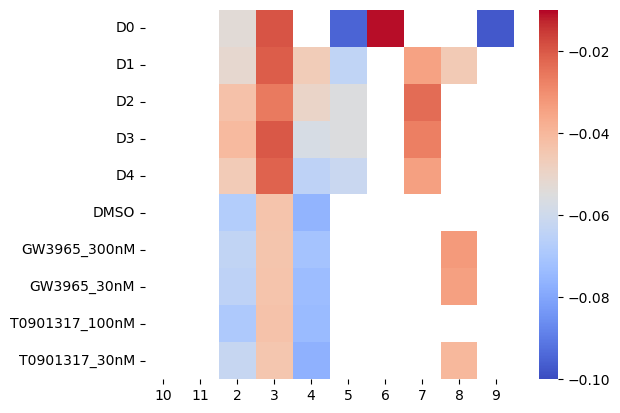

In [197]:
import seaborn as sn
sn.heatmap(heatscoregt,xticklabels = totaltypes[1:],yticklabels=total_treatments,cmap="coolwarm",square = True,vmax=-0.01,vmin=-0.1)
plt.savefig('results/ipsc_immune_response_gt.pdf')

Series([], Name: neuron_differentiation_score, dtype: float64)
Series([], Name: neuron_differentiation_score, dtype: float64)
Series([], Name: neuron_differentiation_score, dtype: float64)
Series([], Name: neuron_differentiation_score, dtype: float64)
Series([], Name: neuron_differentiation_score, dtype: float64)
Series([], Name: neuron_differentiation_score, dtype: float64)
Series([], Name: neuron_differentiation_score, dtype: float64)
Series([], Name: neuron_differentiation_score, dtype: float64)
Series([], Name: neuron_differentiation_score, dtype: float64)
Series([], Name: neuron_differentiation_score, dtype: float64)


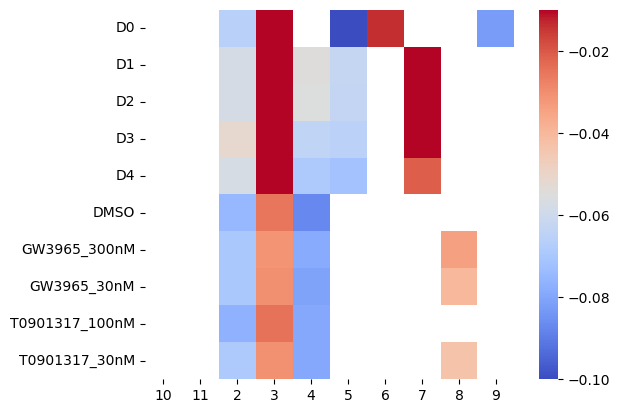

In [198]:
heatscoresemi = np.zeros((len(total_treatments),len(totaltypes)-1))
setscores = semisdata.obs['neuron_differentiation_score']

dmsoscore = np.zeros(len(totaltypes))
c1score =  np.zeros(len(total_treatments))

dmsomask = semisdata.obs['treatment'] == total_treatments[0]
for j in range(len(totaltypes)):
    typemask = np.array(semisdata.obs['celltypes']) == totaltypes[j]
    setscore = setscores[np.logical_and(dmsomask,typemask)]
    dmsoscore[j] = setscore.mean()

for i in range(len(total_treatments)):
    tmask = np.array(semisdata.obs['treatment']) == total_treatments[i]
    c1mask = np.array(semisdata.obs['celltypes']) == '1'
    setscore = setscores[np.logical_and(tmask,c1mask)]
    c1score[i] = setscore.mean()

    
for i in range(len(total_treatments)):
    treatmask = semisdata.obs['treatment'] == total_treatments[i]
    for j in range(1,len(totaltypes)):
        typemask = semisdata.obs['celltypes'] == totaltypes[j]
        mask = np.logical_and(treatmask,typemask)
        setscore = setscores[mask]
        if np.isnan(setscore.mean()):
            print(setscore)
            
        if mask.sum()>100:
            heatscoresemi[i,j-1] = setscore.mean() - c1score[i]
        else:
            heatscoresemi[i,j-1] = np.nan
        #heatscoresemi[i,j-1] = setscore.mean() - c1score[i]

    
sn.heatmap(heatscoresemi,xticklabels = totaltypes[1:],yticklabels=total_treatments,cmap="coolwarm",square = True,vmax=-0.01,vmin=-0.1)
plt.savefig('results/ipsc_immune_response_semi.pdf')

In [ ]:
np.array(heatscoregt).shape

In [193]:
sgt = np.array(heatscoregt)
sgt = np.nan_to_num(sgt,0)
ssemi = np.array(heatscoresemi)
ssemi = np.nan_to_num(ssemi,0)
sgt = sgt.reshape((-1))
ssemi = ssemi.reshape((-1))

In [194]:
import scipy

scipy.stats.pearsonr(sgt,ssemi)

PearsonRResult(statistic=0.9534191830371799, pvalue=8.253278773028199e-53)

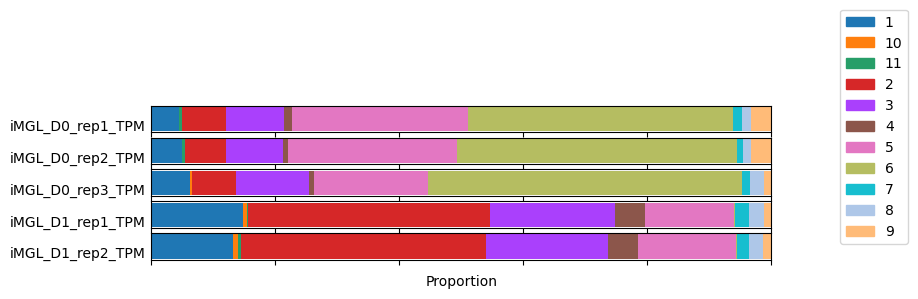

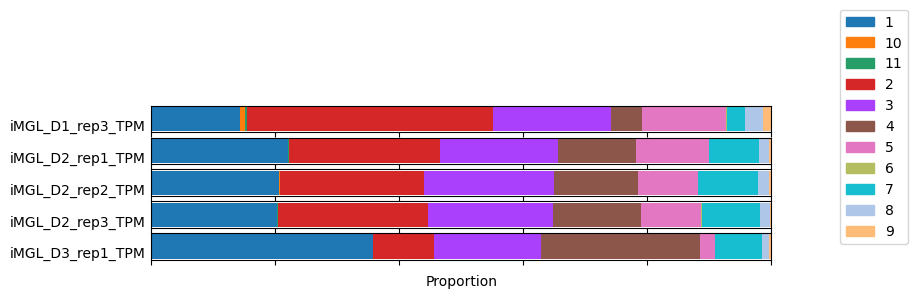

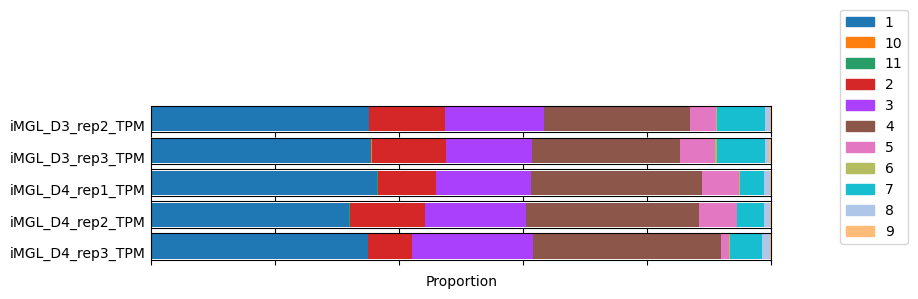

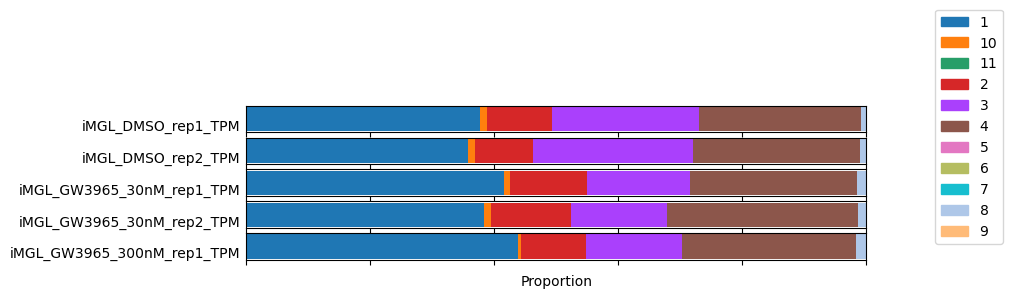

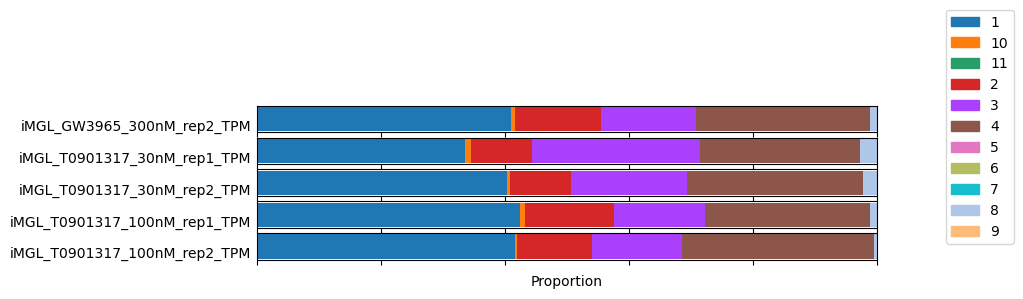

In [202]:
for i in range(5):
    nps = i*5
    
    ppids = pids[nps:nps+5]
    ppsemis = psemis[nps:nps+5]
    ppgts = pgts[nps:nps+5]
    ylabels = pids[nps:nps+5]
    
    
    
    # Create a horizontal stacked bar chart for Condition 1
    title =  ''
    

    
    
    fig, ax = plt.subplots(len(ppids),1,figsize = (8,2))
    ax[0].set_title(title)
    
    
    for j in range(len(ppids)):
        for i in range(len(totaltypes)):
            ax[j].barh(ylabels[j], ppgts[j][i], left=sum(ppgts[j][:i]),color=colormap[i])
            ax[j].set_ylabel(ylabels[j],rotation=0,ha='right',y=-0.05)
            ax[j].set_xlim([0, 1])
            ax[j].set_yticklabels([])
            ax[j].yaxis.set_tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
            #if j != 7:
            ax[j].set_xticklabels([])
    
    
    patches = []
    for i in range(len(totaltypes)):
        patches.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches, loc='center left', bbox_to_anchor=(1.1, 5))

    '''
    patches1 = []
    for i in range(len(totaltypes)//2):
        patches1.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-2].legend(handles=patches1, loc='center left', bbox_to_anchor=(1.07, 3.8))
    
    patches2 = []
    for i in range(9,18):
        patches2.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches2, loc='center left', bbox_to_anchor=(1.3, 5))
    '''
    
    plt.xlabel('Proportion')


    plt.savefig('supdeconv/gt_' + str(nps) + 'to' + str(nps+5)+ '.pdf',bbox_inches='tight')

### Enrichment:  tissue Markers by Cell Type

In [433]:
# GO Bio Process Terms

for selectedtype in totaltypes:
    gttypedata = gtdata[np.array(gtdata.obs['celltype'] == selectedtype),:]
    sc.tl.rank_genes_groups(gttypedata, 'sample_origin', method='t-test')
    #sc.pl.rank_genes_groups(gtdata, n_genes=50, sharey=False)
    gtdeg = []
    for j in range(len(total_tissues)):
        for i in range(50):
            g = gttypedata.uns['rank_genes_groups']['names'][i][j]
            if g not in gtdeg:
                gtdeg.append(g)

    semistypedata = semisdata[np.array(semisdata.obs['celltypes'] == selectedtype),:]
    sc.tl.rank_genes_groups(semistypedata, 'sample_origin', method='t-test')
    #sc.pl.rank_genes_groups(gtdata, n_genes=50, sharey=False)
    #sc.pl.rank_genes_groups(semistypedata, n_genes=25, sharey=False)
    semideg = []
    for j in range(len(total_tissues)):
        for i in range(50):
            g = semistypedata.uns['rank_genes_groups']['names'][i][j]
            if g not in semideg:
                semideg.append(g)
    c=0
    for i in semideg:
        if i in gtdeg:
            c+=1

    #hyperpval = hypert(genesum,50,50,overlap)
    f=open('results/tissue_marker_go/'+selectedtype + 'deg.txt','w')
    f.write('semi: '+str(len(semideg))+'\n')
    f.write('gt: '+str(len(gtdeg))+'\n')
    f.write('overlap: '+str(c)+'\n')
    #f.write('pval:' + str(hyperpval))
    f.close()
    results = gseapy.enrichr(gene_list=gtdeg, gene_sets='GO_Biological_Process_2021',outdir='gseapygt')
    f=open('gseapygt/GO_Biological_Process_2021.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()

    gtsets=[]
    gtps=[]
    gtdic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        gtsets.append(term)
        gtps.append(p)
        gtdic[term] = p

    results = gseapy.enrichr(gene_list=semideg, gene_sets='GO_Biological_Process_2021',outdir='gseapysemi')

    f=open('gseapysemi/GO_Biological_Process_2021.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()
    semisets=[]
    semips=[]
    semidic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        semisets.append(term)
        semips.append(p)
        semidic[term]=p
    terms = copy.deepcopy(gtsets[:10])
    real_data = copy.deepcopy(gtps[:10])
    sim_data = []
    for i in range(10):
        gtterm = semisets[i]
        if gtterm not in semidic.keys():
            sim_data.append(1)
        else:
            sim_data.append(semidic[gtterm])


    for i in range(10):
        if semisets[i] in terms:
            continue
        terms.append(semisets[i])
        sim_data.append(semips[i])
        if semisets[i] not in gtdic.keys():
            real_data.append(1)
        else:
            real_data.append(gtdic[semisets[i]])
    real_data = np.flip(real_data)
    sim_data = np.flip(sim_data)
    terms = np.flip(terms)
    sim_bar_lengths = [-np.log10(p) for p in sim_data]
    real_bar_lengths = [-np.log10(p) for p in real_data]
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
    bar_width = 0.4
    y = np.arange(len(sim_data))+1
    ax1.barh(y, real_bar_lengths, height=bar_width, color='green', label='Real')
    ax1.set_xlabel('-log10(p)')
    ax1.set_ylabel('Term')
    ax1.set_title('Real Data ('+str(len(semideg))+' DEGs)')
    ax2.barh(y, sim_bar_lengths, height=bar_width, color='blue', label='Simulated')
    ax2.set_xlabel('-log10(p)')
    ax2.set_title('Semi-profiled Data('+str(len(gtdeg))+' DEGs)')
    max_val = max(max(sim_bar_lengths), max(real_bar_lengths))
    ax1.set_xlim(0,max_val + 1)
    ax2.set_xlim(0, max_val + 1)
    ax1.invert_xaxis()
    ax1.set_yticks(y)
    ax2.set_yticklabels(terms)
    fig.subplots_adjust(hspace=0.2)
    fig.suptitle(selectedtype + ' GO Biological Process('+str(c)+' Overlap DEGs)')
    plt.savefig('results/tissue_marker_go/'+selectedtype + ' GO Biological Process.pdf',bbox_inches='tight')
    plt.savefig('results/tissue_marker_go/'+selectedtype + ' GO Biological Process.png',dpi=600,bbox_inches='tight')
    plt.show()

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


KeyError: 'sample_origin'

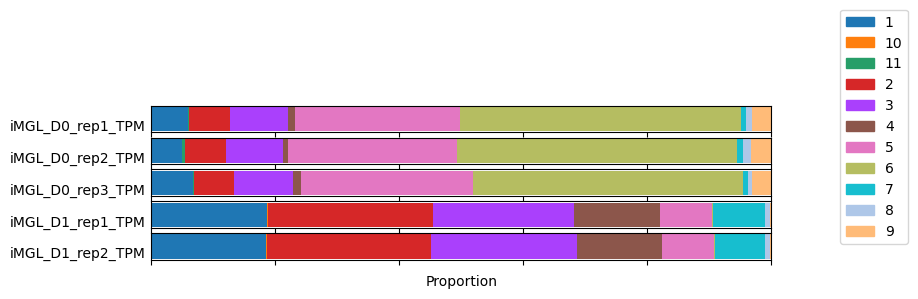

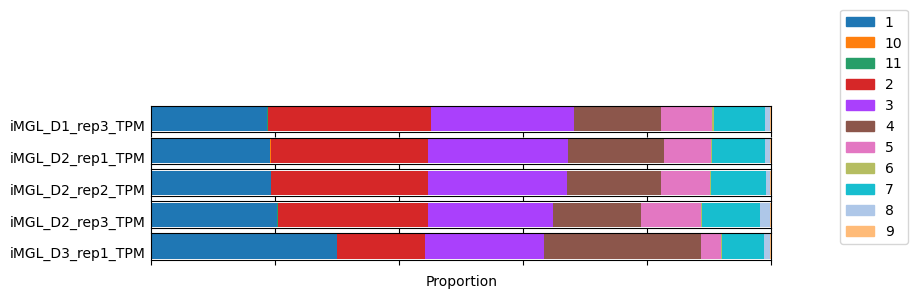

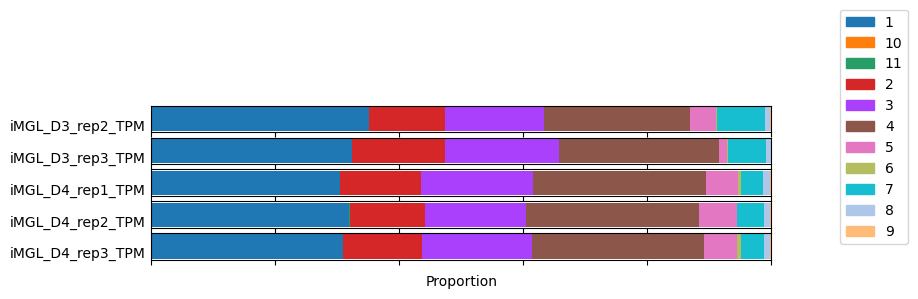

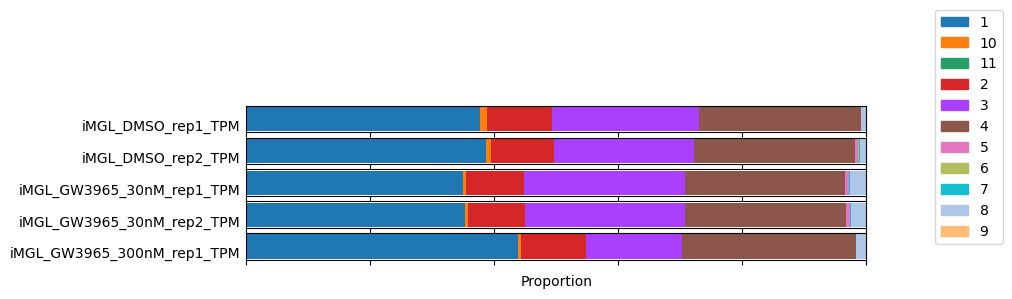

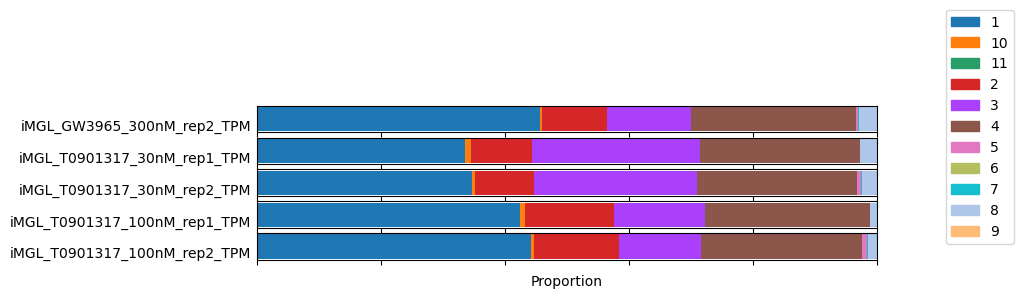

In [203]:
for i in range(5):
    nps = i*5
    
    ppids = pids[nps:nps+5]
    ppsemis = psemis[nps:nps+5]
    ppgts = pgts[nps:nps+5]
    ylabels = pids[nps:nps+5]
    
    
    
    # Create a horizontal stacked bar chart for Condition 1
    title =  ''
    

    
    
    fig, ax = plt.subplots(len(ppids),1,figsize = (8,2))
    ax[0].set_title(title)
    
    
    for j in range(len(ppids)):
        for i in range(len(totaltypes)):
            ax[j].barh(ylabels[j], ppsemis[j][i], left=sum(ppsemis[j][:i]),color=colormap[i])
            ax[j].set_ylabel(ylabels[j],rotation=0,ha='right',y=-0.05)
            ax[j].set_xlim([0, 1])
            ax[j].set_yticklabels([])
            ax[j].yaxis.set_tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
            #if j != 7:
            ax[j].set_xticklabels([])
    
    
    patches = []
    for i in range(len(totaltypes)):
        patches.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches, loc='center left', bbox_to_anchor=(1.1, 5))

    '''
    patches1 = []
    for i in range(len(totaltypes)//2):
        patches1.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-2].legend(handles=patches1, loc='center left', bbox_to_anchor=(1.07, 3.8))
    
    patches2 = []
    for i in range(9,18):
        patches2.append(mpatches.Patch(color=colormap[i], label=totaltypes[i]))
    ax[-1].legend(handles=patches2, loc='center left', bbox_to_anchor=(1.3, 5))
    '''
    
    plt.xlabel('Proportion')


    plt.savefig('supdeconv/semi_' + str(nps) + 'to' + str(nps+5)+ '.pdf',bbox_inches='tight')

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


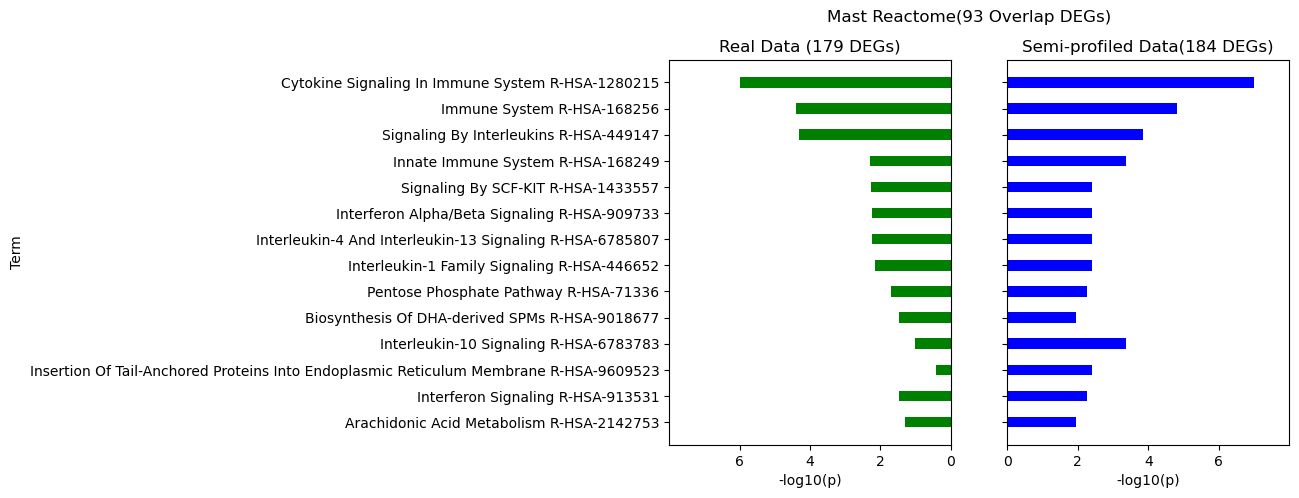

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


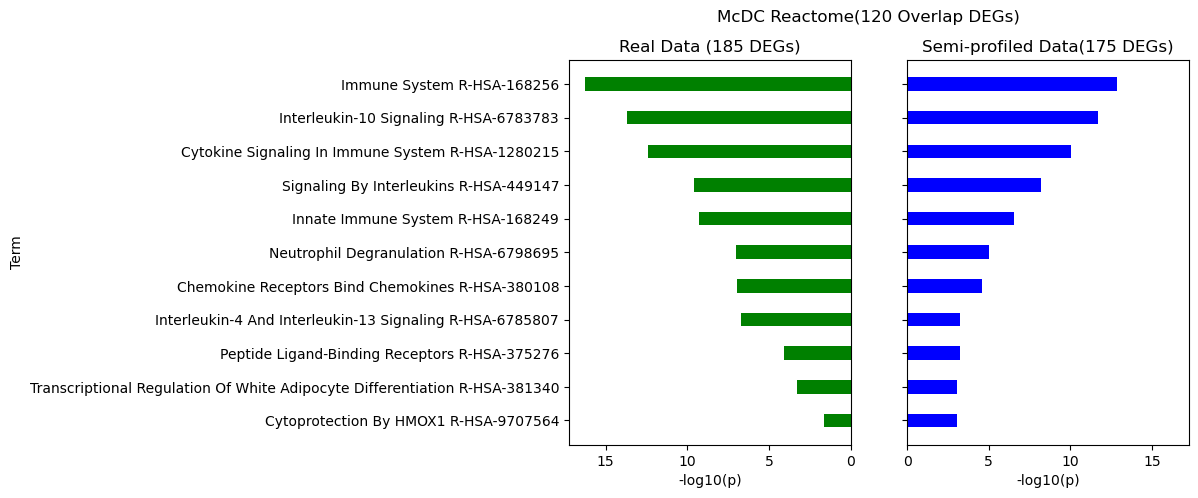

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


IndexError: invalid index (2)

In [379]:
# Reactome terms
for selectedtype in totaltypes[5:]:
    gttypedata = gtdata[np.array(gtdata.obs['celltypes'] == selectedtype),:]
    sc.tl.rank_genes_groups(gttypedata, 'sample_origin', method='t-test')
    #sc.pl.rank_genes_groups(gtdata, n_genes=50, sharey=False)
    gtdeg = []
    for j in range(len(total_tissues)):
        for i in range(50):
            g = gttypedata.uns['rank_genes_groups']['names'][i][j]
            if g not in gtdeg:
                gtdeg.append(g)

    semistypedata = semisdata[np.array(semisdata.obs['celltypes'] == selectedtype),:]
    sc.tl.rank_genes_groups(semistypedata, 'sample_origin', method='t-test')
    #sc.pl.rank_genes_groups(gtdata, n_genes=50, sharey=False)
    #sc.pl.rank_genes_groups(semistypedata, n_genes=25, sharey=False)
    semideg = []
    for j in range(len(total_tissues)):
        for i in range(50):
            g = semistypedata.uns['rank_genes_groups']['names'][i][j]
            if g not in semideg:
                semideg.append(g)
    c=0
    for i in semideg:
        if i in gtdeg:
            c+=1

    f=open('results/tissue_marker_reactome/'+selectedtype + 'deg.txt','w')
    f.write('semi: '+str(len(semideg))+'\n')
    f.write('gt: '+str(len(gtdeg))+'\n')
    f.write('overlap: '+str(c)+'\n')
    f.close()
    results = gseapy.enrichr(gene_list=gtdeg, gene_sets='Reactome_2022',outdir='gseapygt')
    f=open('gseapygt/Reactome_2022.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()

    gtsets=[]
    gtps=[]
    gtdic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        gtsets.append(term)
        gtps.append(p)
        gtdic[term] = p

    results = gseapy.enrichr(gene_list=semideg, gene_sets='Reactome_2022',outdir='gseapysemi')

    f=open('gseapysemi/Reactome_2022.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()
    semisets=[]
    semips=[]
    semidic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        semisets.append(term)
        semips.append(p)
        semidic[term]=p
    terms = copy.deepcopy(gtsets[:10])
    real_data = copy.deepcopy(gtps[:10])
    sim_data = []
    for i in range(10):
        gtterm = semisets[i]
        if gtterm not in semidic.keys():
            sim_data.append(1)
        else:
            sim_data.append(semidic[gtterm])


    for i in range(10):
        if semisets[i] in terms:
            continue
        terms.append(semisets[i])
        sim_data.append(semips[i])
        if semisets[i] not in gtdic.keys():
            real_data.append(1)
        else:
            real_data.append(gtdic[semisets[i]])
    real_data = np.flip(real_data)
    sim_data = np.flip(sim_data)
    terms = np.flip(terms)
    sim_bar_lengths = [-np.log10(p) for p in sim_data]
    real_bar_lengths = [-np.log10(p) for p in real_data]
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
    bar_width = 0.4
    y = np.arange(len(sim_data))+1
    ax1.barh(y, real_bar_lengths, height=bar_width, color='green', label='Real')
    ax1.set_xlabel('-log10(p)')
    ax1.set_ylabel('Term')
    ax1.set_title('Real Data ('+str(len(semideg))+' DEGs)')
    ax2.barh(y, sim_bar_lengths, height=bar_width, color='blue', label='Simulated')
    ax2.set_xlabel('-log10(p)')
    ax2.set_title('Semi-profiled Data('+str(len(gtdeg))+' DEGs)')
    max_val = max(max(sim_bar_lengths), max(real_bar_lengths))
    ax1.set_xlim(0,max_val + 1)
    ax2.set_xlim(0, max_val + 1)
    ax1.invert_xaxis()
    ax1.set_yticks(y)
    ax2.set_yticklabels(terms)
    fig.suptitle(selectedtype + ' Reactome('+str(c)+' Overlap DEGs)')
    plt.savefig('results/tissue_marker_reactome/'+selectedtype + ' Reactome.pdf',bbox_inches='tight')
    plt.savefig('results/tissue_marker_reactome/'+selectedtype + ' Reactome.png',dpi=600,bbox_inches='tight')
    plt.show()

In [435]:
gtdata.obs['celltypes'] = gtdata.obs['celltype']

In [27]:
semisdata

AnnData object with n_obs × n_vars = 72133 × 6013
    obs: 'sample_ids', 'celltypes', 'repmask'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'celltypes_colors', 'celltypes_sizes', 'neighbors', 'paga', 'repmask_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

### CellType Markers Enrichment

In [29]:
totaltypes = np.unique(gtdata.obs['celltype'])

In [30]:
totaltypes

array(['1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype=object)

In [31]:


### Reactome

sc.tl.rank_genes_groups(gtdata, 'celltype', method='t-test')

typededic = {}
for j in range(totaltypes.shape[0]):
    celltype = totaltypes[j]
    typede = []
    for i in range(100):
        g = gtdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
        
    typededic[celltype] = typede



sc.tl.rank_genes_groups(semisdata, 'celltypes', method='t-test')

semitypededic = {}
for j in range(totaltypes.shape[0]):
    celltype = totaltypes[j]
    typede = []
    for i in range(100):
        g = semisdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
        
    semitypededic[celltype] = typede




In [39]:
hyperpval = hypert(semisdata.X.shape[1],100,100,c)

In [33]:
import scipy

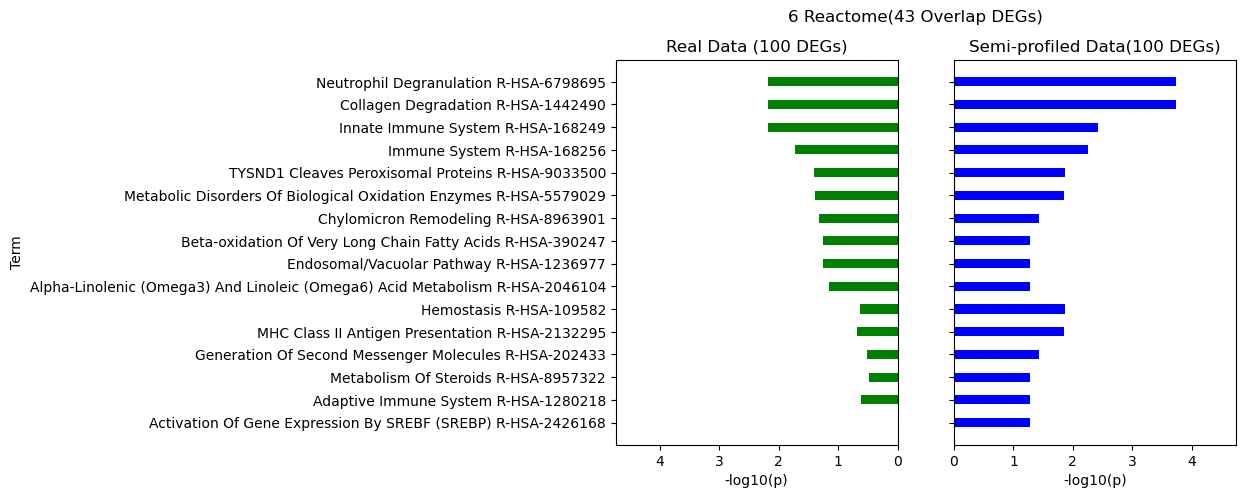

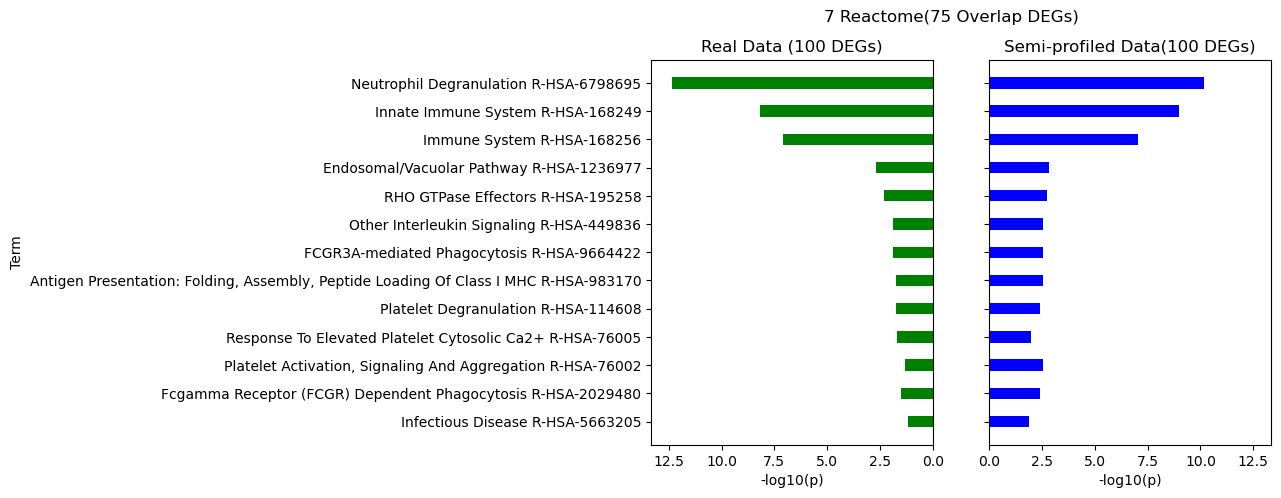

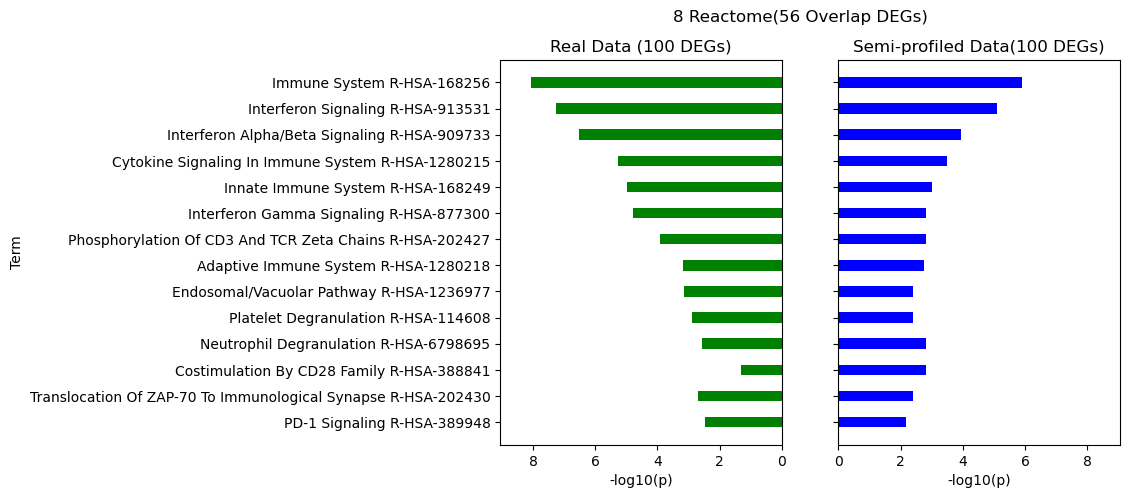

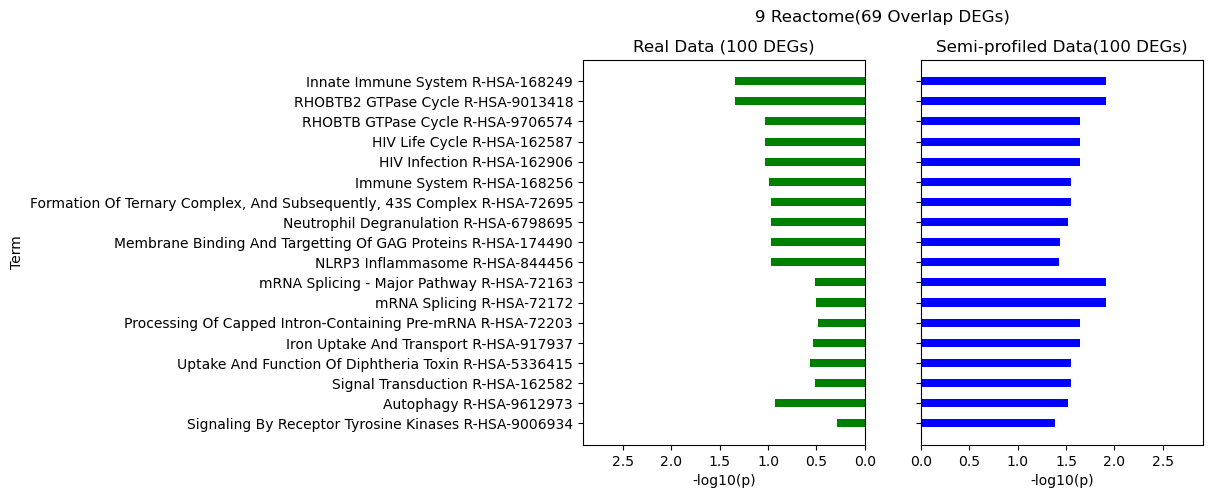

In [54]:

for j in range(7,totaltypes.shape[0]):
    selectedtype = totaltypes[j]
    c=0
    gtdeg = typededic[totaltypes[j]]
    semideg = semitypededic[totaltypes[j]]
    for i in semideg:
        if i in gtdeg:
            c+=1
            
    hyperpval = hypert(semisdata.X.shape[1],100,100,c)


    results = gseapy.enrichr(gene_list=gtdeg, gene_sets='Reactome_2022',outdir='gseapygt')
    f=open('gseapygt/Reactome_2022.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()

    gtsets=[]
    gtps=[]
    gtdic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        gtsets.append(term)
        gtps.append(p)
        gtdic[term] = p

    results = gseapy.enrichr(gene_list=semideg, gene_sets='Reactome_2022',outdir='gseapysemi')

    f=open('gseapysemi/Reactome_2022.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()
    semisets=[]
    semips=[]
    semidic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        semisets.append(term)
        semips.append(p)
        semidic[term]=p
    terms = copy.deepcopy(gtsets[:10])
    real_data = copy.deepcopy(gtps[:10])
    sim_data = []
    for i in range(10):
        gtterm = semisets[i]
        if gtterm not in semidic.keys():
            sim_data.append(1)
        else:
            sim_data.append(semidic[gtterm])


    for i in range(len(totaltypes)):
        if semisets[i] in terms:
            continue
        terms.append(semisets[i])
        sim_data.append(semips[i])
        if semisets[i] not in gtdic.keys():
            real_data.append(1)
        else:
            real_data.append(gtdic[semisets[i]])
            
            
    real_data = np.flip(real_data)
    sim_data = np.flip(sim_data)
    terms = np.flip(terms)
    sim_bar_lengths = [-np.log10(p) for p in sim_data]
    real_bar_lengths = [-np.log10(p) for p in real_data] 
    
    np.save('results/celltype_marker_reactome/' + selectedtype + '_pvals.npy',np.concatenate([(real_data).reshape((-1,1)),(sim_data).reshape((-1,1))],axis=1))
    
    res = scipy.stats.pearsonr(np.array(sim_bar_lengths),np.array(real_bar_lengths))
    f=open('results/celltype_marker_reactome/'+str(totaltypes[j])+'.txt','w')
    f.write('semi: '+str(len(semideg))+'\n')
    f.write('gt: '+str(len(gtdeg))+'\n')
    f.write('overlap: '+str(c)+'\n')
    f.write('pval:' + str(float(hyperpval))+'\n')
    f.write('pcor:' + str(res[0])+'\n')
    f.write('pcor pval:' + str(res[1]))
    f.close()


    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
    bar_width = 0.4
    y = np.arange(len(sim_data))+1
    ax1.barh(y, real_bar_lengths, height=bar_width, color='green', label='Real')
    ax1.set_xlabel('-log10(p)')
    ax1.set_ylabel('Term')
    ax1.set_title('Real Data ('+str(len(semideg))+' DEGs)')
    ax2.barh(y, sim_bar_lengths, height=bar_width, color='blue', label='Simulated')
    ax2.set_xlabel('-log10(p)')
    ax2.set_title('Semi-profiled Data('+str(len(gtdeg))+' DEGs)')
    max_val = max(max(sim_bar_lengths), max(real_bar_lengths))
    ax1.set_xlim(0,max_val + 1)
    ax2.set_xlim(0, max_val + 1)
    ax1.invert_xaxis()
    ax1.set_yticks(y)
    ax2.set_yticklabels(terms)
    fig.suptitle(selectedtype + ' Reactome('+str(c)+' Overlap DEGs)')
    plt.savefig('results/celltype_marker_reactome/'+selectedtype + ' Reactome.pdf',bbox_inches='tight')
    plt.savefig('results/celltype_marker_reactome/'+selectedtype + ' Reactome.png',dpi=600,bbox_inches='tight')
    plt.show()


In [59]:
totaltypes

array(['1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype=object)

In [60]:


for j in range(10,totaltypes.shape[0]):
    selectedtype = totaltypes[j]
    c=0
    gtdeg = typededic[totaltypes[j]]
    semideg = semitypededic[totaltypes[j]]
    for i in semideg:
        if i in gtdeg:
            c+=1
            
    hyperpval = hypert(semisdata.X.shape[1],100,100,c)        
    

    results = gseapy.enrichr(gene_list=gtdeg, gene_sets='GO_Biological_Process_2021',outdir='gseapygt')
    f=open('gseapygt/GO_Biological_Process_2021.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()

    gtsets=[]
    gtps=[]
    gtdic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        gtsets.append(term)
        gtps.append(p)
        gtdic[term] = p
        
        
    

    results = gseapy.enrichr(gene_list=semideg, gene_sets='GO_Biological_Process_2021',outdir='gseapysemi')

    f=open('gseapysemi/GO_Biological_Process_2021.human.enrichr.reports.txt','r')
    lines=f.readlines()
    f.close()
    semisets=[]
    semips=[]
    semidic={}
    for l in lines[1:]:
        term = l.split('\t')[1]
        p = float(l.split('\t')[4])
        semisets.append(term)
        semips.append(p)
        semidic[term]=p
    terms = copy.deepcopy(gtsets[:10])
    real_data = copy.deepcopy(gtps[:10])
    sim_data = []
    for i in range(10):
        gtterm = semisets[i]
        if gtterm not in semidic.keys():
            sim_data.append(1)
        else:
            sim_data.append(semidic[gtterm])


    for i in range(10):
        if semisets[i] in terms:
            continue
        terms.append(semisets[i])
        sim_data.append(semips[i])
        if semisets[i] not in gtdic.keys():
            real_data.append(1)
        else:
            real_data.append(gtdic[semisets[i]])
    real_data = np.flip(real_data)
    sim_data = np.flip(sim_data)
    terms = np.flip(terms)
    sim_bar_lengths = [-np.log10(p) for p in sim_data]
    real_bar_lengths = [-np.log10(p) for p in real_data]
    
    
    
    np.save('results/celltype_marker_go/' + selectedtype + '_pvals.npy',np.concatenate([(real_data).reshape((-1,1)),(sim_data).reshape((-1,1))],axis=1))
    
    res = scipy.stats.pearsonr(np.array(sim_bar_lengths),np.array(real_bar_lengths))
    f=open('results/celltype_marker_go/'+str(totaltypes[j])+'.txt','w')
    f.write('semi: '+str(len(semideg))+'\n')
    f.write('gt: '+str(len(gtdeg))+'\n')
    f.write('overlap: '+str(c)+'\n')
    f.write('pval:' + str(float(hyperpval))+'\n')
    f.write('pcor:' + str(res[0])+'\n')
    f.write('pcor pval:' + str(res[1]))
    f.close()

    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 5))
    bar_width = 0.4
    y = np.arange(len(sim_data))+1
    ax1.barh(y, real_bar_lengths, height=bar_width, color='green', label='Real')
    ax1.set_xlabel('-log10(p)')
    ax1.set_ylabel('Term')
    ax1.set_title('Real Data ('+str(len(semideg))+' DEGs)')
    ax2.barh(y, sim_bar_lengths, height=bar_width, color='blue', label='Simulated')
    ax2.set_xlabel('-log10(p)')
    ax2.set_title('Semi-profiled Data('+str(len(gtdeg))+' DEGs)')
    max_val = max(max(sim_bar_lengths), max(real_bar_lengths))
    ax1.set_xlim(0,max_val + 1)
    ax2.set_xlim(0, max_val + 1)
    ax1.invert_xaxis()
    ax1.set_yticks(y)
    ax2.set_yticklabels(terms)
    fig.suptitle(selectedtype + ' GO('+str(c)+' Overlap DEGs)')
    plt.savefig('results/celltype_marker_go/'+selectedtype + ' GO .pdf',bbox_inches='tight')
    plt.savefig('results/celltype_marker_go/'+selectedtype + ' GO .png',dpi=600,bbox_inches='tight')
    plt.show()

ValueError: Warning: No enrich terms when cutoff = 0.05

In [ ]:
1+1

### End of Enrichment

In [104]:
semisdata

AnnData object with n_obs × n_vars = 72133 × 6013
    obs: 'sample_ids', 'celltypes', 'repmask'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'repmask_colors'
    obsm: 'X_umap'

### end of activated version of enrichment

## PAGA

In [108]:
sc.pp.neighbors(semisdata,n_neighbors = 50, use_rep='X_pca')

In [109]:
sc.tl.paga(semisdata,groups = 'celltypes')

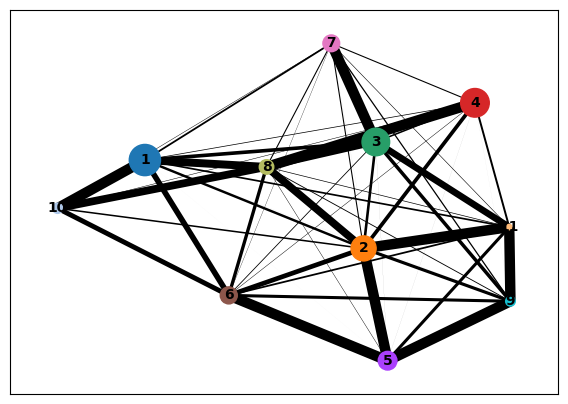

In [110]:
sc.pl.paga(semisdata, plot=True,threshold=0)#,save='semi_paga_threshold_threshold0_t10_8rep.pdf')

In [111]:
gtdata.obsm['X_pca'].shape

(74372, 100)

In [112]:
sc.pp.neighbors(gtdata,n_neighbors = 50,use_rep='X_pca')

In [113]:
sc.tl.paga(gtdata, groups = 'celltype')

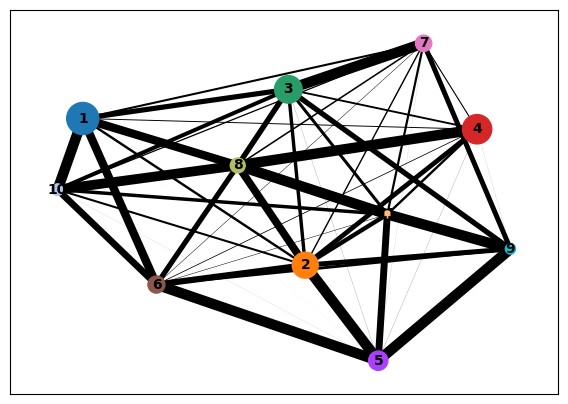

In [114]:
sc.pl.paga(gtdata, plot=True,threshold=0)#,save='gt_paga_threshold0_t10_8rep.pdf')

In [115]:
semisdata.write('semisdata_withcelltype.h5ad')
gtdata.write('gtdata_withcelltype.h5ad')


In [116]:
semisdata

AnnData object with n_obs × n_vars = 72133 × 6013
    obs: 'sample_ids', 'celltypes', 'repmask'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'repmask_colors', 'neighbors', 'paga', 'celltypes_sizes', 'celltypes_colors'
    obsm: 'X_umap', 'X_pca'
    obsp: 'distances', 'connectivities'

In [117]:
gtdata

AnnData object with n_obs × n_vars = 74372 × 6013
    obs: 'celltype', 'sample_ids'
    var: 'gene_symbols', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'neighbors', 'paga', 'celltype_sizes', 'celltype_colors'
    obsm: 'X_umap', 'X_pca'
    obsp: 'distances', 'connectivities'

In [118]:
gtpaga = np.array(gtdata.uns['paga']['connectivities'].todense())
semipaga = np.array(semisdata.uns['paga']['connectivities'].todense())
gtpaga = gtpaga.reshape((-1))
semipaga= semipaga.reshape((-1))
scipy.stats.pearsonr(gtpaga,semipaga)

PearsonRResult(statistic=0.8651766899716611, pvalue=1.793936582917317e-37)

In [66]:
semipaga.shape

(11, 11)

In [41]:
path = ['Mono_prolif','CD14','CD16']

### Marker genes dotplot

In [451]:
sc.tl.rank_genes_groups(gtdata, 'celltypes', method='t-test')

In [452]:
sc.tl.rank_genes_groups(semisdata, 'celltypes', method='t-test')

In [453]:
gt_markers = []
semi_markers = []
for j in range(totaltypes.shape[0]):
    typede = []
    for i in range(4):
        g = gtdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
    gt_markers = gt_markers + typede
    
    typede = []
    for i in range(4):
        g = semisdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
    semi_markers = semi_markers + typede

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


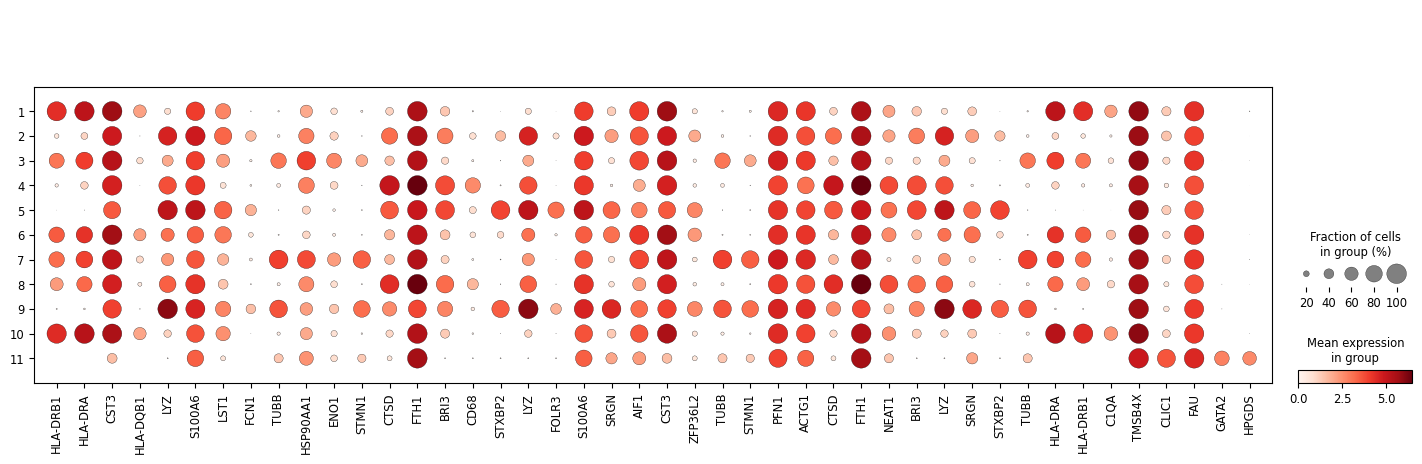

In [454]:
sc.pl.dotplot(gtdata, gt_markers, groupby='celltypes',save = 't10_dot_gt.pdf')#.style(cmap='Blues',dot_edge_color='black', dot_edge_lw=1).swap_axes(False).show(True)

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


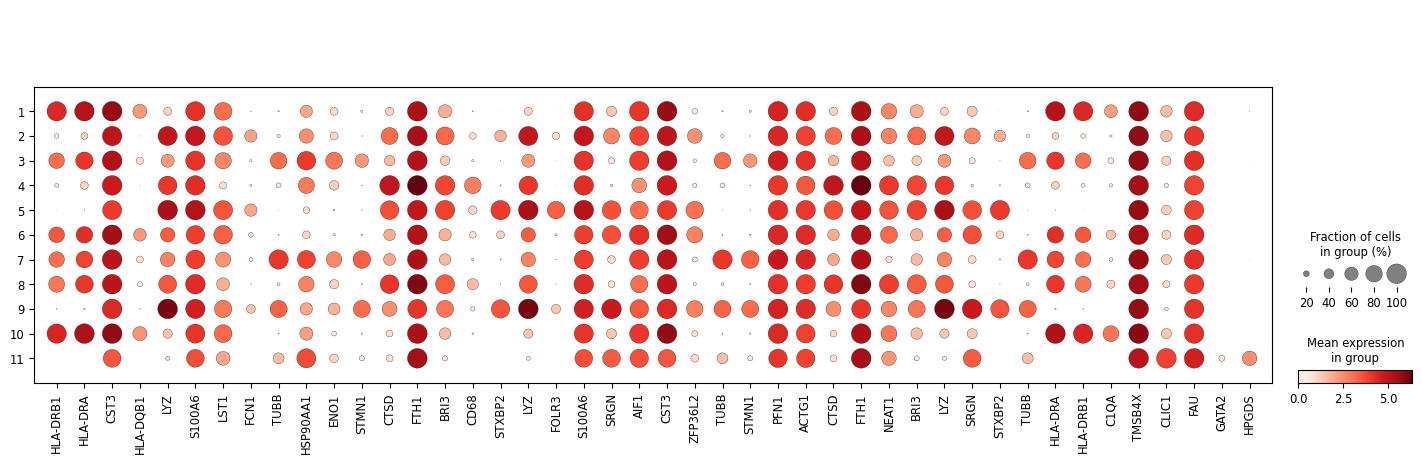

In [455]:
sc.pl.dotplot(semisdata, gt_markers, groupby='celltypes',save = 't10_dot_semi.pdf')#.style(cmap='Blues',dot_edge_color='black', dot_edge_lw=1).swap_axes(False).show(True)

In [456]:
dpgt = sc.pl.dotplot(gtdata, gt_markers, groupby='celltypes',return_fig=True)
dpgtsize = (dpgt.dot_size_df.to_numpy())
dpgtcolor = (dpgt.dot_color_df.to_numpy())

In [457]:
dp = sc.pl.dotplot(semisdata, gt_markers, groupby='celltypes',return_fig=True)
dpcolor = (dp.dot_color_df.to_numpy())
dpsize = (dp.dot_size_df.to_numpy())

In [458]:
from scipy import stats
res = stats.pearsonr(dpgtsize.flatten(), dpsize.flatten())
print('size',res)
res = stats.pearsonr(dpgtcolor.flatten(), dpcolor.flatten())
print('color',res)

size PearsonRResult(statistic=0.9801343877839934, pvalue=0.0)
color PearsonRResult(statistic=0.9890179192110615, pvalue=0.0)


### Psuedotime using PAGA path

In [510]:
totaltypes

array(['1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype='<U21')

In [511]:
path_markers_gt = []
path_markers_semi = []
for j in range(totaltypes.shape[0]):
    typede = []
    for i in range(5):
        g = gtdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
    path_markers_gt = path_markers_gt + typede
    
    typede = []
    for i in range(5):
        g = semisdata.uns['rank_genes_groups']['names'][i][j]
        typede.append(g)
    path_markers_semi = path_markers_semi + typede


In [180]:
gtdata.uns['iroot'] = np.flatnonzero(gtdata.obs['celltypes'] == 'Entericglial')[0]
semisdata.uns['iroot'] = np.flatnonzero(semisdata.obs['celltypes'] == 'Entericglial')[0]
semisdatat.uns['iroot'] = np.flatnonzero(semisdata.obs['celltypes'] == 'Entericglial')[0]
#sumap.obs['initial_clustering'] = np.array(list(gtdata.obs['initial_clustering'])+list(semisdata.obs['initial_clustering']))
#sumap.uns['iroot'] = np.flatnonzero(sumap.obs['initial_clustering'] == 'Lymph_prolif')[0]

In [181]:
sc.tl.diffmap(gtdata)
sc.tl.dpt(gtdata)

In [182]:
sc.tl.diffmap(semisdata)
sc.tl.dpt(semisdata)

In [185]:
sc.pp.neighbors(semisdatat,use_rep='X_pca_a')

In [186]:
sc.tl.diffmap(semisdatat)
sc.tl.dpt(semisdatat)

In [133]:
gtdata.obs['jointdps'] = sumap.obs['dpt_pseudotime'][:lengt]
semisdata.obs['jointdps'] = sumap.obs['dpt_pseudotime'][lengt:]

In [56]:
#gtdata.obs['dpt_pseudotime_raw'] = gtdata.obs['dpt_pseudotime'] 

In [137]:
#for i in range(len(semisdata.obs['jointdps'])):
#    if np.isnan(semisdata.obs['jointdps'][i]):
#        semisdata.obs['jointdps'][i] = 0

### end of pseudotime
### start RRHO

In [459]:
# find both positivee and negative markers
sc.tl.rank_genes_groups(gtdata, 'celltypes', method='t-test',rankby_abs=True)

In [460]:
sc.tl.rank_genes_groups(semisdata, 'celltypes', method='t-test',rankby_abs=True)

In [461]:
from mpmath import *
mp.dps=500

In [462]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpmath import *
def c(a,b):
    a=mp.mpf(a)
    b=mp.mpf(b)
    cab = fac(a)/fac(a-b)/fac(b)
    return cab

def hyperp(N,n1,n2,k):
    N = mp.mpf(N)
    n1 = mp.mpf(n1)
    n2 = mp.mpf(n2)
    k = mp.mpf(k)
    p = c(n2,k)*c(N-n2,n1-k)/c(N,n1)
    return p 

def hypert(N,n1,n2,k):
    cdf = mp.mpf(0)
    for i in range(0,int(k)+1):
        cdf += hyperp(N,n1,n2,i)
       # print()
    return (1-cdf)

def rrho_plot(list1, list2, list3, list4, celltype,upperbound=5):

    
    n1 = len(list1) # gt pos
    n2 = len(list2) # semi pos
    n3 = len(list3) # gt neg
    n4 = len(list4) # semi neg

    # Calculate the maximum rank to consider
    max_rank1 = max(n3, n2)
    max_rank2 = max(n3, n4)
    max_rank3 = max(n1, n2)
    max_rank4 = max(n1, n4)

    # Initialize the RRHO plot matrix
    rrho_matrix1 = np.zeros((max_rank1, max_rank1))
    rrho_matrix2 = np.zeros((max_rank2, max_rank2))
    rrho_matrix3 = np.zeros((max_rank3, max_rank3))
    rrho_matrix4 = np.zeros((max_rank4, max_rank4))
    
    # Iterate over different cutoff ranks
    upper=1e-50
    ## ax1 
    for rank1 in range(1, max_rank1 + 1):
        for rank2 in range(1, max_rank1 + 1):
            # Get the top genes up to the cutoff ranks
            top_genes1 = set(list1[:rank1])
            top_genes2 = set(list4[:rank2])
            union = np.unique(list(top_genes1) + list(top_genes2))
            # Calculate the overlap between the two gene sets
            overlap = len(top_genes1.intersection(top_genes2))
            # Calculate the hypergeometric p-value for the overlap
            p_value = hypert(int(hvmask.sum()),rank1,rank2,overlap)#1 - scipy.stats.hypergeom.cdf(overlap, 6000, rank1, rank2)
            #print(p_value)
            p_value = float(p_value)
            if p_value < upper:
                p_value = upper
            if np.isnan(p_value):
                print(overlap, len(union), rank1, rank2)
            # Store the negative logarithm of the p-value in the RRHO matrix
            rrho_matrix1[rank1 - 1, rank2 - 1] = -np.log10(p_value)
    #ax2
    for rank1 in range(1, max_rank2 + 1):
        for rank2 in range(1, max_rank2 + 1):
            # Get the top genes up to the cutoff ranks
            top_genes1 = set(list1[:rank1])
            top_genes2 = set(list2[:rank2])
            union = np.unique(list(top_genes1) + list(top_genes2))
            # Calculate the overlap between the two gene sets
            overlap = len(top_genes1.intersection(top_genes2))
            # Calculate the hypergeometric p-value for the overlap
            p_value = hypert(int(hvmask.sum()),rank1,rank2,overlap)#1 - scipy.stats.hypergeom.cdf(overlap, 6000, rank1, rank2)
            #print(p_value)
            p_value = float(p_value)
            if p_value < upper:
                p_value = upper
            if np.isnan(p_value):
                print(overlap, len(union), rank1, rank2)
            # Store the negative logarithm of the p-value in the RRHO matrix
            rrho_matrix2[rank1 - 1, rank2 - 1] = -np.log10(p_value)
            
    for rank1 in range(1, max_rank3 + 1):
        for rank2 in range(1, max_rank3 + 1):
            # Get the top genes up to the cutoff ranks
            top_genes1 = set(list3[:rank1])
            top_genes2 = set(list4[:rank2])
            union = np.unique(list(top_genes1) + list(top_genes2))
            # Calculate the overlap between the two gene sets
            overlap = len(top_genes1.intersection(top_genes2))
            # Calculate the hypergeometric p-value for the overlap
            p_value = hypert(int(hvmask.sum()),rank1,rank2,overlap)#1 - scipy.stats.hypergeom.cdf(overlap, 6000, rank1, rank2)
            #print(p_value)
            p_value = float(p_value)
            if p_value < upper:
                p_value = upper
            if np.isnan(p_value):
                print(overlap, len(union), rank1, rank2)
            # Store the negative logarithm of the p-value in the RRHO matrix
            rrho_matrix3[rank1 - 1, rank2 - 1] = -np.log10(p_value)
            
    for rank1 in range(1, max_rank4 + 1):
        for rank2 in range(1, max_rank4 + 1):
            # Get the top genes up to the cutoff ranks
            top_genes1 = set(list3[:rank1])
            top_genes2 = set(list2[:rank2])
            union = np.unique(list(top_genes1) + list(top_genes2))
            # Calculate the overlap between the two gene sets
            overlap = len(top_genes1.intersection(top_genes2))
            # Calculate the hypergeometric p-value for the overlap
            p_value = hypert(int(hvmask.sum()),rank1,rank2,overlap)#1 - scipy.stats.hypergeom.cdf(overlap, 6000, rank1, rank2)
            #print(p_value)
            p_value = float(p_value)
            if p_value < upper:
                p_value = upper
            if np.isnan(p_value):
                print(overlap, len(union), rank1, rank2)
            # Store the negative logarithm of the p-value in the RRHO matrix
            rrho_matrix4[rank1 - 1, rank2 - 1] = -np.log10(p_value)
            
            
    fig, axs = plt.subplots(2, 2,figsize=(6,6))

    cmap = 'magma'#'coolwarm' # inferno
    
    rrho_matrix2 = np.flip(rrho_matrix2,axis=1)
    rrho_matrix3 = np.flip(rrho_matrix3,axis=0)
    rrho_matrix4 = np.flip(np.flip(rrho_matrix4,axis=0),axis=1)
    
    vmx = 50
    # Plot heatmap in the first quadrant
    im1 = axs[0, 0].imshow(rrho_matrix1, cmap=cmap,vmax=vmx, aspect='auto')
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticks([])
    # Plot heatmap in the second quadrant
    im2 = axs[0, 1].imshow(rrho_matrix2, cmap=cmap,vmax=vmx, aspect='auto')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    # Plot heatmap in the third quadrant
    im3 = axs[1, 0].imshow(rrho_matrix3, cmap=cmap,vmax=vmx, aspect='auto')
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])
    # Plot heatmap in the fourth quadrant
    im4 = axs[1, 1].imshow(rrho_matrix4, cmap=cmap,vmax=vmx, aspect='auto')
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])
    #plt.title(celltype + ' Markers RRHO Plot')
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.savefig('results/RRHO50_'+celltype+'.pdf')
    plt.show()
    # Plot the RRHO heatmap
    
    plt.imshow(rrho_matrix2, cmap=cmap, aspect='auto')
    plt.colorbar(label='-log10(p)')
    #plt.xlabel('Semii-profiled Markers')
    #plt.ylabel('Real Markers')
    #plt.title(celltype + ' Markers RRHO Plot')

    plt.xticks(list(range(0,n1,n1//10))) 
    plt.yticks(list(range(0,n2,n2//10))) 

    #plt.clim(0,upperbound)
    plt.savefig('results/RRHO50_colorbar.pdf')
    plt.show()
    
    return rrho_matrix1,rrho_matrix2,rrho_matrix3,rrho_matrix4




In [463]:
def rrho(j=0,nummarkers=100,upperbound=5):
    gt_markers1 = []
    semi_markers1 = []

    celltype = totaltypes[j]

    for i in range(nummarkers):
        g = gtdata.uns['rank_genes_groups']['names'][i][j]
        gt_markers1.append(g)
    for i in range(nummarkers):
        g = semisdatat.uns['rank_genes_groups']['names'][i][j]
        semi_markers1.append(g)

    rmat = rrho_plot(gt_markers1, semi_markers1,celltype,upperbound)

In [464]:
mp.dps=500

1
1


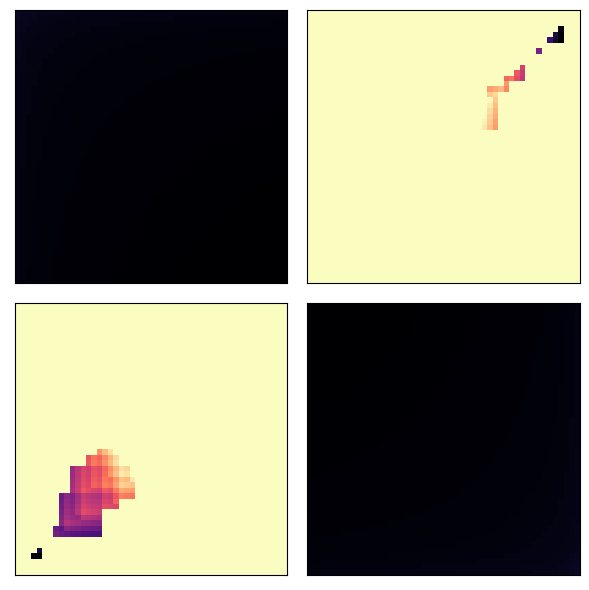

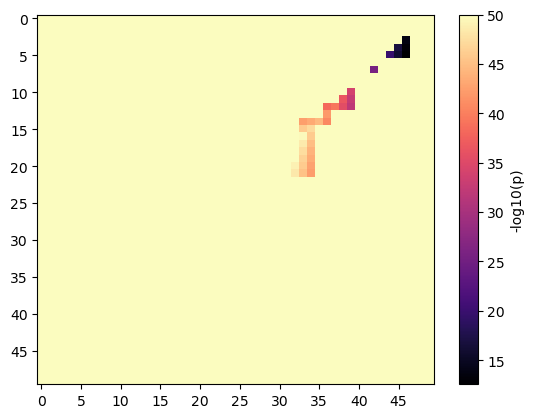

10
1


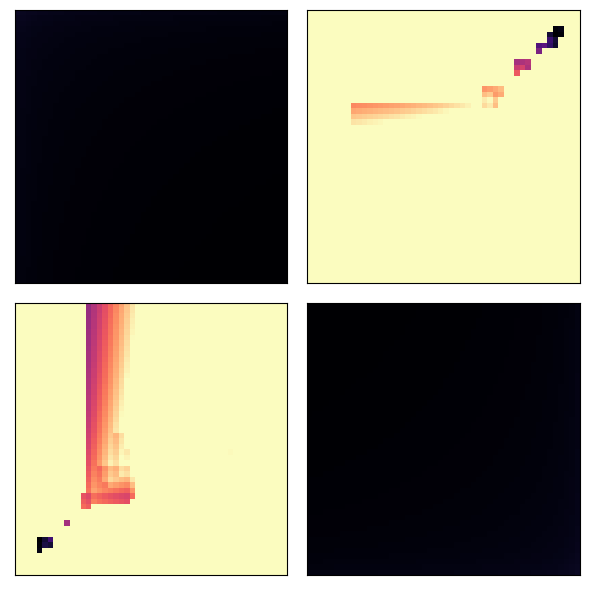

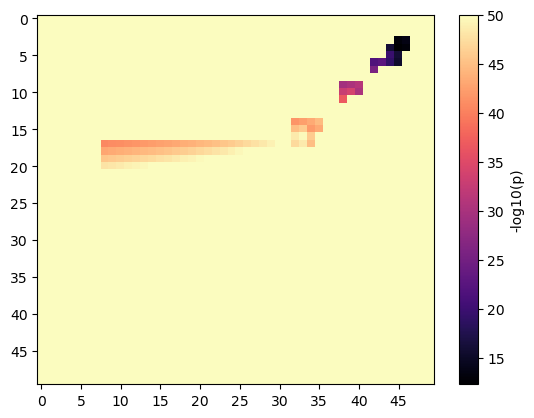

11
1


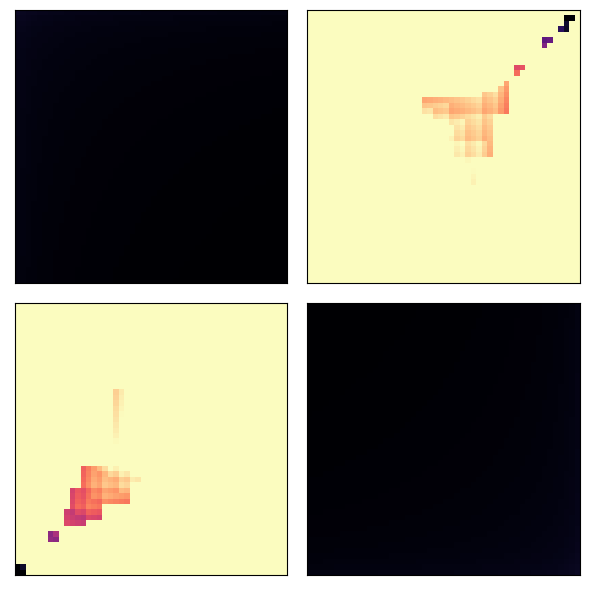

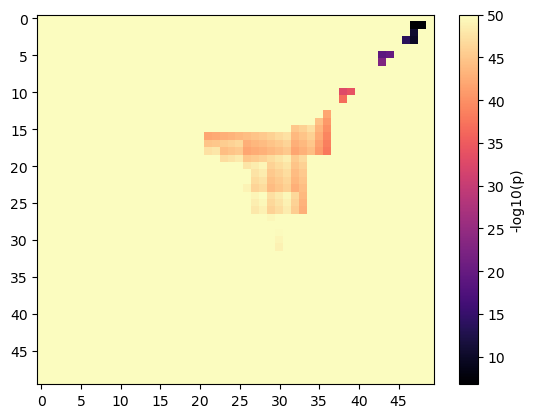

2
1


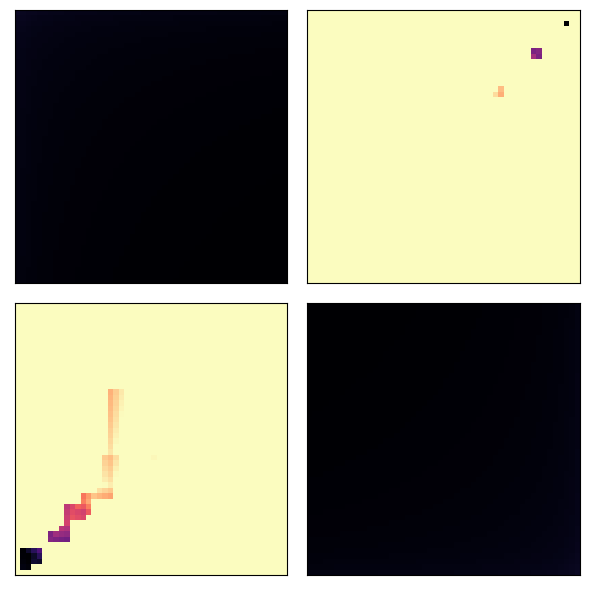

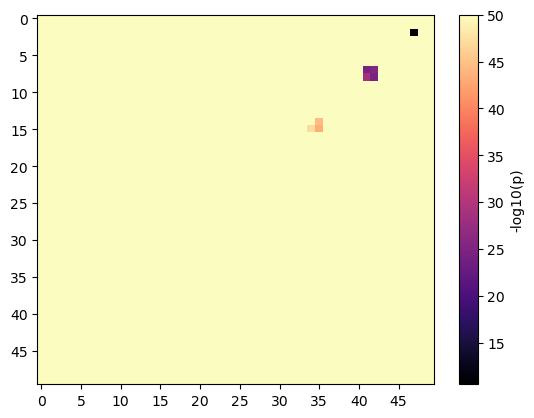

3
1


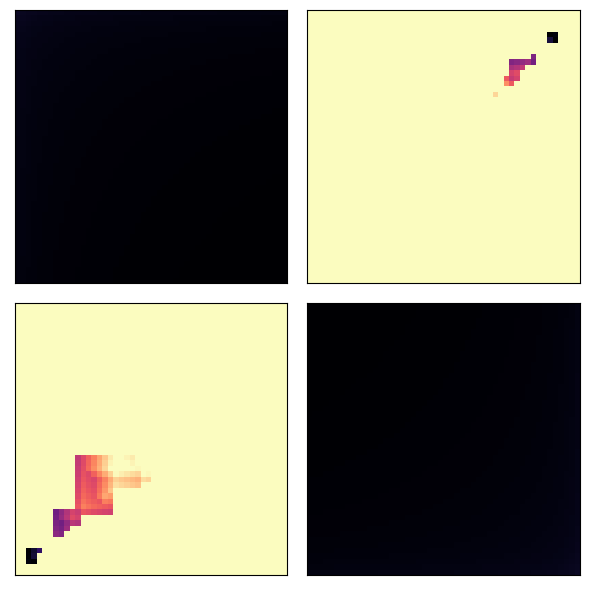

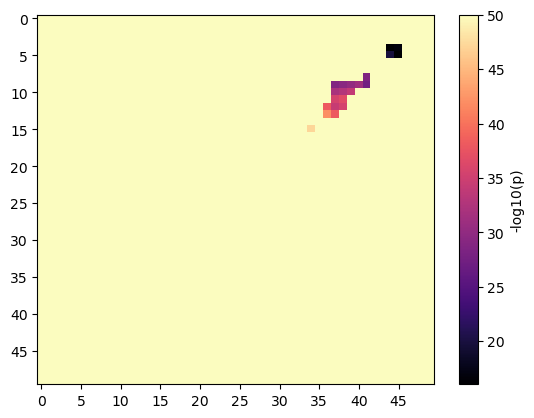

4
1


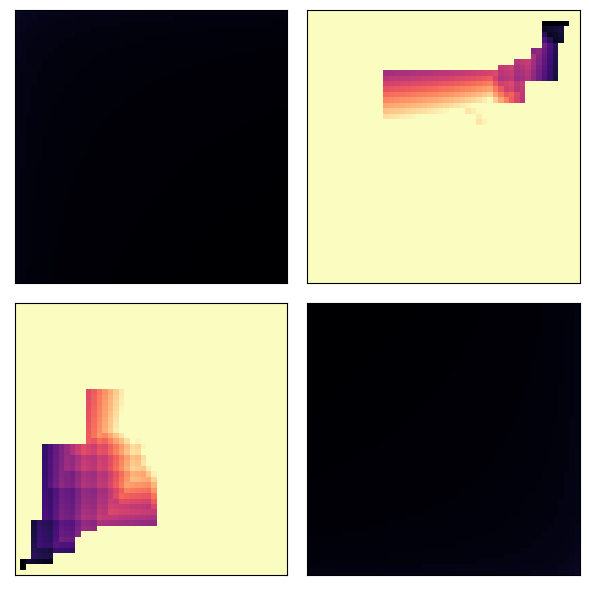

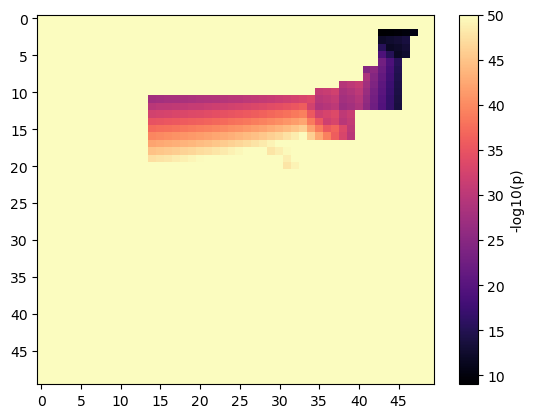

5
1


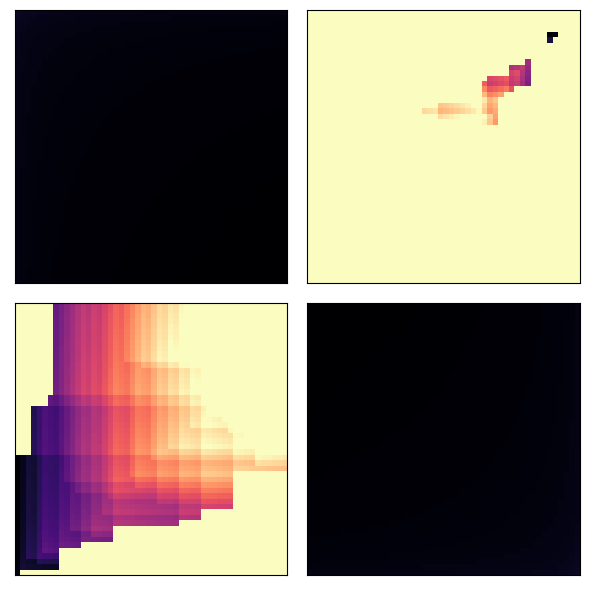

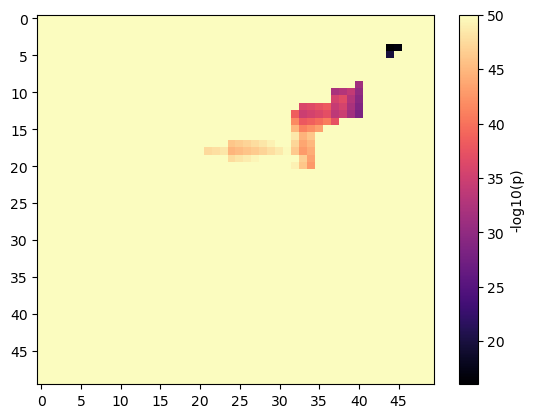

6
1


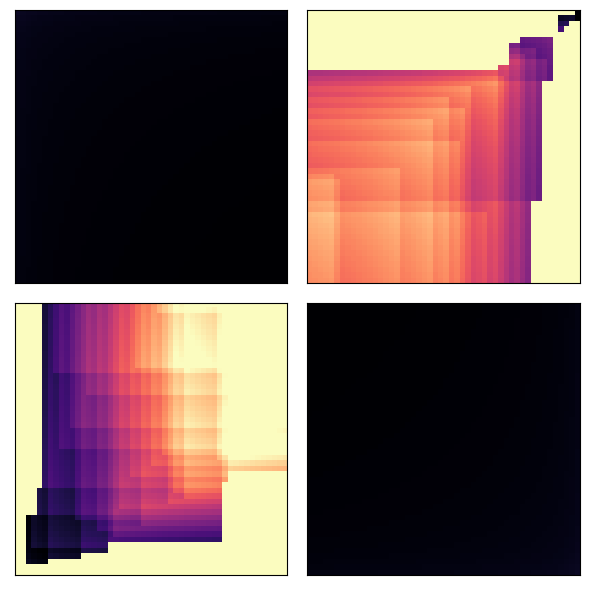

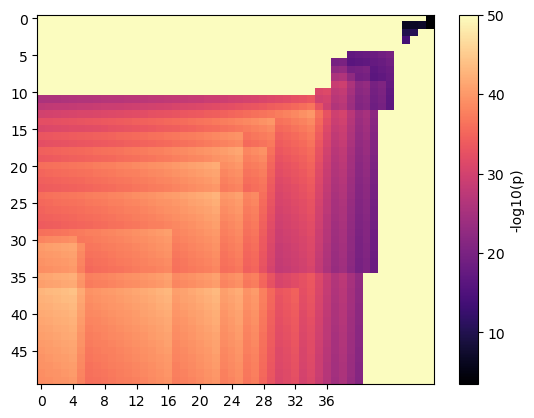

7
1


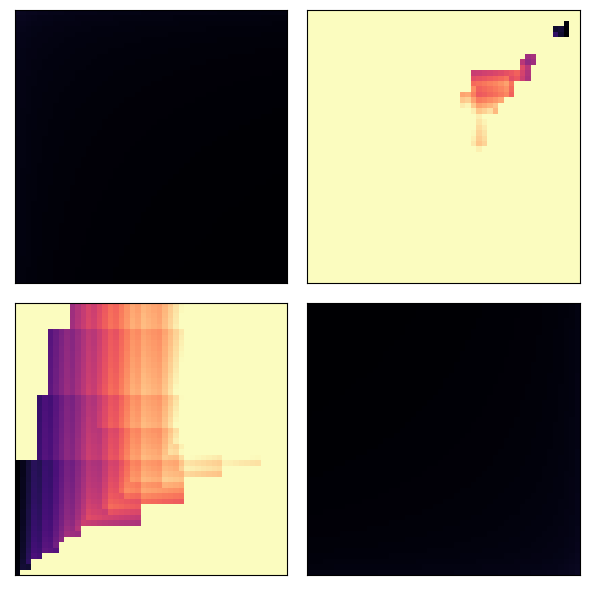

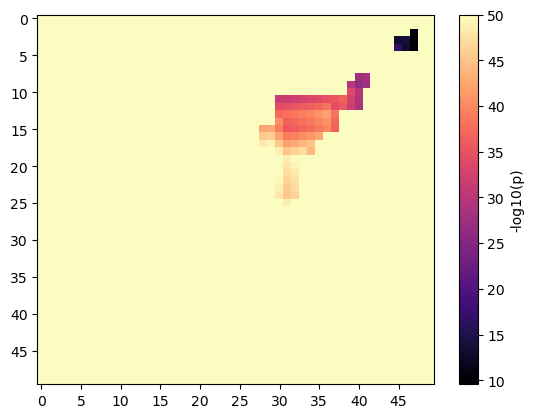

8
1


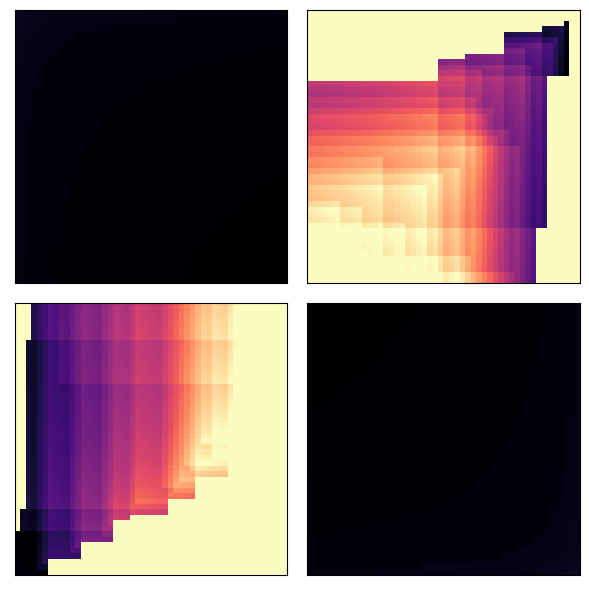

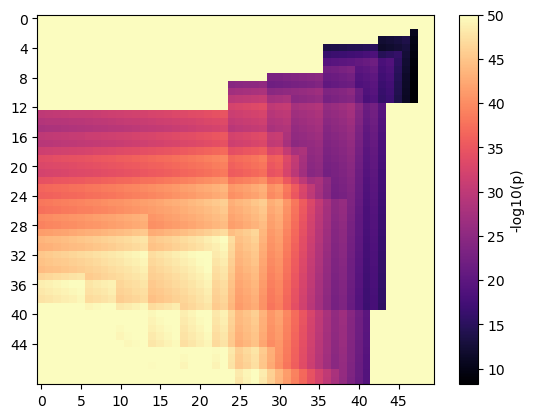

9
1


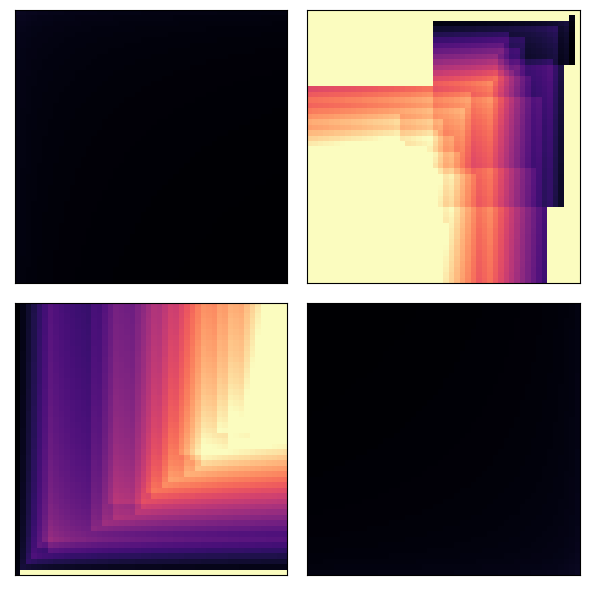

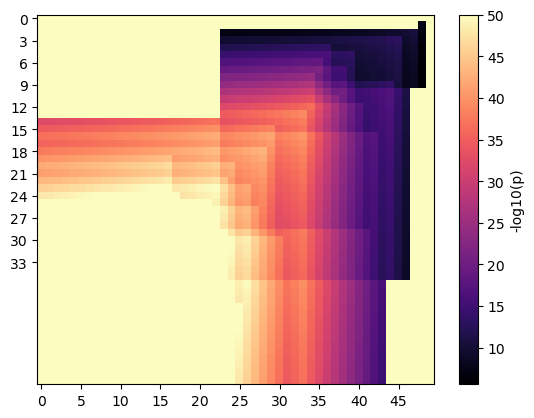

In [465]:
upperbound=50
for j in range(0,len(totaltypes)):
    celltype = totaltypes[j]
    print(celltype)

    nummarkers = 1000
    gt_posmarkers = []
    gt_negmarkers = []
    semi_posmarkers = []
    semi_negmarkers = []
    
    # gt
    for i in range(nummarkers):
        g = gtdata.uns['rank_genes_groups']['names'][i][j]
        score = gtdata.uns['rank_genes_groups']['scores'][i][j]
        if score > 0:
            gt_posmarkers.append(g)
        else:
            gt_negmarkers.append(g)
    #semii
    for i in range(nummarkers):
        g = semisdata.uns['rank_genes_groups']['names'][i][j]
        score = semisdata.uns['rank_genes_groups']['scores'][i][j]
        if score > 0:
            semi_posmarkers.append(g)
        else:
            semi_negmarkers.append(g)

    ngenes = 50
    gt_posmarkers = gt_posmarkers[:ngenes]
    semi_posmarkers = semi_posmarkers[:ngenes]
    gt_negmarkers = gt_negmarkers[:ngenes]
    semi_negmarkers = semi_negmarkers[:ngenes]
    #print(len(gt_posmarkers))
    #print(len(semi_posmarkers))
    #print(len(gt_negmarkers))
    #print(len(semi_negmarkers))
    print(1)
    rmat = rrho_plot(list1 = gt_posmarkers, \
                     list2 = semi_posmarkers,\
                     list3 = gt_negmarkers,\
                     list4 = semi_negmarkers,\
                     celltype = celltype, upperbound = upperbound)

In [ ]:
totalterms = 14
print('pval:',float(hypert(int(hvmask.sum()),10,10,20 - totalterms)))

In [202]:
1 - scipy.stats.hypergeom.cdf(13, 6000, 10, 10)

0.0

In [339]:
semisdatat

AnnData object with n_obs × n_vars = 221502 × 4053
    obs: 'patient_ids', 'sample_ids', 'sample_origin', 'celltypes'
    var: 'gene_symbols'
    uns: 'rank_genes_groups', 'celltypes_colors'
    obsm: 'X_pca_a', 'X_umap_a', 'X_umap', 'X_umap_sc_a'

In [338]:
Normalsemi = semisdatat[semisdatat.obs['sample_origin']=='Normal']
Normalgt = gtdata[gtdata.obs['sample_origin']=='Normal']

LymphNodesemi = semisdatat[semisdatat.obs['sample_origin']=='LymphNode']
LymphNodegt = gtdata[gtdata.obs['sample_origin']=='LymphNode']

Tumoresemi = semisdatat[semisdatat.obs['sample_origin']=='Tumor']
Tumoregt = gtdata[gtdata.obs['sample_origin']=='Tumor']

Tumor2semi = semisdatat[semisdatat.obs['sample_origin']=='Tumor-2']
Tumor2gt = gtdata[gtdata.obs['sample_origin']=='Tumor-2']


In [340]:
Normalsemi.write('Normalsemi.h5ad')
Normalgt.write('Normalgt.h5ad')

LymphNodesemi.write('LymphNodesemi.h5ad')
LymphNodegt.write('LymphNodegt.h5ad')

Tumoresemi.write('Tumoresemi.h5ad')
Tumoregt.write('Tumoregt.h5ad')

Tumor2semi.write('Tumor2semi.h5ad')
Tumor2gt.write('Tumor2gt.h5ad')

In [341]:
sps = sparse.csr_matrix(Normalsemi.X)
Normalsemisps = anndata.AnnData(sps)
Normalsemisps.obs = Normalsemi.obs
Normalsemisps.var = Normalsemi.var
Normalsemisps.obsm = Normalsemi.obsm
Normalsemisps.uns = Normalsemi.uns
Normalsemisps.write('Normalsemisps.h5ad')


sps = sparse.csr_matrix(Normalgt.X)
Normalgtsps = anndata.AnnData(sps)
Normalgtsps.obs = Normalgt.obs
Normalgtsps.var = Normalgt.var
Normalgtsps.obsm = Normalgt.obsm
Normalgtsps.uns = Normalgt.uns
Normalgtsps.write('Normalgtsps.h5ad')


sps = sparse.csr_matrix(LymphNodesemi.X)
LymphNodesemisps = anndata.AnnData(sps)
LymphNodesemisps.obs = LymphNodesemi.obs
LymphNodesemisps.var = LymphNodesemi.var
LymphNodesemisps.obsm = LymphNodesemi.obsm
LymphNodesemisps.uns = LymphNodesemi.uns
LymphNodesemisps.write('LymphNodesemisps.h5ad')



sps = sparse.csr_matrix(LymphNodegt.X)
LymphNodegtsps = anndata.AnnData(sps)
LymphNodegtsps.obs = LymphNodegt.obs
LymphNodegtsps.var = LymphNodegt.var
LymphNodegtsps.obsm = LymphNodegt.obsm
LymphNodegtsps.uns = LymphNodegt.uns
LymphNodegtsps.write('LymphNodegtsps.h5ad')


sps = sparse.csr_matrix(Tumoresemi.X)
Tumoresemisps = anndata.AnnData(sps)
Tumoresemisps.obs = Tumoresemi.obs
Tumoresemisps.var = Tumoresemi.var
Tumoresemisps.obsm = Tumoresemi.obsm
Tumoresemisps.uns = Tumoresemi.uns
Tumoresemisps.write('Tumoresemisps.h5ad')


sps = sparse.csr_matrix(Tumoregt.X)
Tumoregtsps = anndata.AnnData(sps)
Tumoregtsps.obs = Tumoregt.obs
Tumoregtsps.var = Tumoregt.var
Tumoregtsps.obsm = Tumoregt.obsm
Tumoregtsps.uns = Tumoregt.uns
Tumoregtsps.write('Tumoregtsps.h5ad')


sps = sparse.csr_matrix(Tumor2semi.X)
Tumor2semisps = anndata.AnnData(sps)
Tumor2semisps.obs = Tumor2semi.obs
Tumor2semisps.var = Tumor2semi.var
Tumor2semisps.obsm = Tumor2semi.obsm
Tumor2semisps.uns = Tumor2semi.uns
Tumor2semisps.write('Tumor2semisps.h5ad')


sps = sparse.csr_matrix(Tumor2gt.X)
Tumor2gtsps = anndata.AnnData(sps)
Tumor2gtsps.obs = Tumor2gt.obs
Tumor2gtsps.var = Tumor2gt.var
Tumor2gtsps.obsm = Tumor2gt.obsm
Tumor2gtsps.uns = Tumor2gt.uns
Tumor2gtsps.write('Tumor2gtsps.h5ad')


In [342]:
Normalsemi

View of AnnData object with n_obs × n_vars = 55180 × 4053
    obs: 'patient_ids', 'sample_ids', 'sample_origin', 'celltypes'
    var: 'gene_symbols'
    uns: 'rank_genes_groups', 'celltypes_colors'
    obsm: 'X_pca_a', 'X_umap_a', 'X_umap', 'X_umap_sc_a'

In [343]:
from scipy import sparse

In [344]:
totaltypes

array(['B', 'Endothelial', 'Entericglial', 'Epithelial', 'Fibroblast',
       'Mast', 'McDC', 'Neutrophils', 'PlasmaB', 'T_NK', 'pDC'],
      dtype=object)

In [353]:


#selected_types=['B_cell', 'CD14', 'CD16', 'CD4', 'CD8', 'DCs']
for ctype in ['Entericglial']:# totaltypes:
    
    semitypedata = semisdatat[semisdatat.obs['celltypes']==ctype]
    gttypeda = gtdata[gtdata.obs['celltypes']==ctype]

    # gttypeda.write(str(ctype)+'_gtdata.h5ad')
    # semitypedata.write(str(ctype)+'_semidata.h5ad')
        
    print(str(ctype)+'_semidata_sparse.h5ad',str(gttypedata.X.shape[0]))
    
    gtsps = sparse.csr_matrix(np.array(gttypeda.X))
    semisps = sparse.csr_matrix(np.array(semitypedata.X))
    
    gttypedata = anndata.AnnData(gtsps)
    gttypedata.obs = gttypeda.obs
    gttypedata.var = gttypeda.var
    gttypedata.obsm = gttypeda.obsm
    gttypedata.uns = gttypeda.uns
    gttypedata.obsp = gttypeda.obsp
    
    semitypedatasps = anndata.AnnData(semisps)
    semitypedatasps.obs = semitypedata.obs
    semitypedatasps.var = semitypedata.var
    semitypedatasps.obsm = semitypedata.obsm
    semitypedatasps.uns = semitypedata.uns
    semitypedatasps.obsp = semitypedata.obsp
    
    gttypedata.write(str(ctype)+'_gtdata_sparse.h5ad')
    semitypedatasps.write(str(ctype)+'_semidata_sparse.h5ad')

Entericglial_semidata_sparse.h5ad 463


In [354]:
gttypedata

AnnData object with n_obs × n_vars = 2840 × 4053
    obs: 'patient_ids', 'celltypes', 'sample_ids', 'sample_origin', 'celltypecolor', 'ft', 'dpt_pseudotime'
    var: 'gene_symbols'
    uns: 'ft_colors', 'rank_genes_groups', 'neighbors', 'paga', 'celltypes_sizes', 'celltypes_colors', 'iroot', 'diffmap_evals'
    obsm: 'X_pca_no_a', 'X_umap_no_a', 'X_pca_a', 'X_umap_a', 'X_umap_sc_a', 'X_umap_sc_no_a', 'X_umap', 'X_diffmap'
    obsp: 'distances', 'connectivities'

In [352]:
for fname in os.listdir('pseudodata'):
    print('scp jingtao2@cps.jundinglab.org:/mnt/data/jingtao2/scpatients/cancer/pseudodata/'+fname+' .')
    print()

scp jingtao2@cps.jundinglab.org:/mnt/data/jingtao2/scpatients/cancer/pseudodata/Endothelial_gtdata_sparse.h5ad .

scp jingtao2@cps.jundinglab.org:/mnt/data/jingtao2/scpatients/cancer/pseudodata/.ipynb_checkpoints .

scp jingtao2@cps.jundinglab.org:/mnt/data/jingtao2/scpatients/cancer/pseudodata/Tumor2gt.h5ad .

scp jingtao2@cps.jundinglab.org:/mnt/data/jingtao2/scpatients/cancer/pseudodata/Epithelial_semidata_sparse.h5ad .

scp jingtao2@cps.jundinglab.org:/mnt/data/jingtao2/scpatients/cancer/pseudodata/Tumoresemi.h5ad .

scp jingtao2@cps.jundinglab.org:/mnt/data/jingtao2/scpatients/cancer/pseudodata/LymphNodesemisps.h5ad .

scp jingtao2@cps.jundinglab.org:/mnt/data/jingtao2/scpatients/cancer/pseudodata/Entericglial_semidata_sparse.h5ad .

scp jingtao2@cps.jundinglab.org:/mnt/data/jingtao2/scpatients/cancer/pseudodata/Mast_semidata_sparse.h5ad .

scp jingtao2@cps.jundinglab.org:/mnt/data/jingtao2/scpatients/cancer/pseudodata/McDC_gtdata_sparse.h5ad .

scp jingtao2@cps.jundinglab.org:/mn

/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


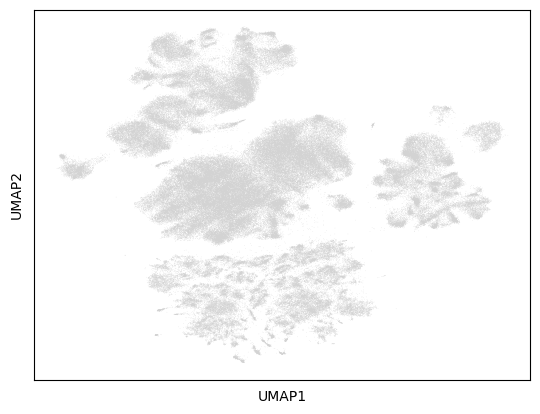

In [347]:
sc.pl.umap(gtdata)

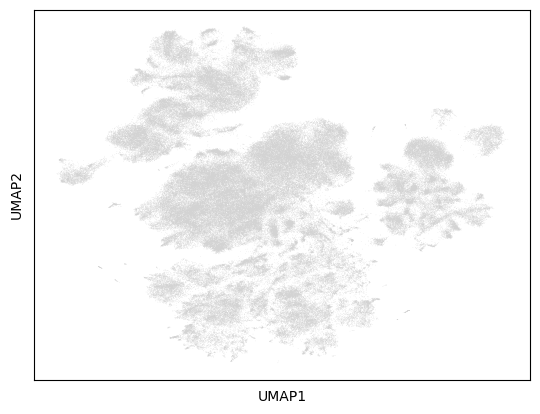

In [348]:
sc.pl.umap(semisdatat)

In [332]:
semisdatat

AnnData object with n_obs × n_vars = 221502 × 4053
    obs: 'patient_ids', 'sample_ids', 'sample_origin', 'celltypes'
    var: 'gene_symbols'
    uns: 'rank_genes_groups'
    obsm: 'X_pca_a', 'X_umap_a', 'X_umap'

In [328]:
semisdatat.obsm['X_umap'] = semisdatat.obsm['X_umap_sc_a']

KeyError: 'X_umap_sc_a'

In [329]:
gtdata.obsm['X_umap'] = gtdata.obsm['X_umap_sc_a']

In [5]:
combdata

AnnData object with n_obs × n_vars = 1397560 × 6000
    obs: 'label'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
combdata = anndata.read_h5ad('combdata_umap.h5ad')

In [7]:
lengt = gtdata.X.shape[0]
semisdata.obsm['X_umap'] = combdata.obsm['X_umap'][lengt:]

In [17]:
selected_types=['B_cell', 'CD14', 'CD16', 'CD4', 'CD8', 'DCs']
for ctype in selected_types:
    #gttypedata = gtdata[gtdata.obs['initial_clustering']==ctype]
    semitypedata = semisdata[semisdata.obs['initial_clustering']==ctype]
    
    
    #gttypedata.write(str(ctype)+'_gtdata.h5ad')
    semitypedata.write(str(ctype)+'_semidata.h5ad')
    

In [9]:
gtdata.X = np.exp(gtdata.X)-1
semisdata.X = np.exp(semisdata.X)-1

In [10]:
import anndata
from scipy import sparse

In [19]:
semitypedata

AnnData object with n_obs × n_vars = 10647 × 6000
    obs: 'initial_clustering', 'dpt_pseudotime'
    var: 'feature_types'
    uns: 'diffmap_evals', 'initial_clustering_colors', 'initial_clustering_sizes', 'iroot', 'neighbors', 'paga'
    obsm: 'X_diffmap', 'X_pca_joint', 'X_umap'
    obsp: 'connectivities', 'distances'

In [21]:
gttypeda

AnnData object with n_obs × n_vars = 6938 × 6000
    obs: 'initial_clustering', 'dpt_pseudotime'
    var: 'feature_types'
    uns: 'diffmap_evals', 'initial_clustering_colors', 'initial_clustering_sizes', 'iroot', 'neighbors', 'paga'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'